In [1]:
#!source /usr/local/Ascend/ascend-toolkit/set_env.sh
import torch

import torch.nn as nn
import math
from functools import partial
from esm.modules import ContactPredictionHead, ESM1bLayerNorm, RobertaLMHead, TransformerLayer, MultiheadAttention 
import esm
from typing import Union

In [ ]:
# print(f"Number of NPU devices: {torch.npu.device_count()}")
# print(f"Current NPU device index: {torch.npu.current_device()}")
# print(f"NPU device name: {torch.npu.get_device_name(torch.npu.current_device())}")

In [ ]:
class GroundingAttention(nn.Module):
    def __init__(self, dim, num_heads=4, qkv_bias=True,
                 attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.kv = nn.Linear(dim, dim*2, bias=qkv_bias)
        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        # self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, r):
        B, N, C = x.shape
        B_, N_, C_ = r.shape

        kv = self.kv(r).reshape(B_, N_, 2, self.num_heads, C_ //
                                self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv.unbind(0)
        q = self.q(x).reshape(B, N, self.num_heads, C //
                              self.num_heads).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, heads, N, N_)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        # x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [ ]:
class FFN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FFN, self).__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        """
        输入 x 的形状: (batch_size, seq_len, input_dim)
        输出 y 的形状: (batch_size, seq_len, output_dim)
        """
        residual = x
        # x = x.view(-1, x.size(-1))  # 将 x 展平成二维
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        # x = x.view(batch_size, seq_len, -1)  # 将 x 恢复成三维
        x = residual + x
        return x

In [ ]:
class bertlayer(nn.Module):
    def __init__(self, embeddingdim, hidden_dim, num_head = 16):
        super(bertlayer, self).__init__()
        self.atte_norm = ESM1bLayerNorm(embeddingdim)
        self.ffn_norm = ESM1bLayerNorm(embeddingdim)
        self.atte = torch.nn.MultiheadAttention(embed_dim = embeddingdim, num_heads = num_head, dropout = 0.0)
        self.ffn = FFN(embeddingdim, hidden_dim)
    def forward(self, x, x_padding_mask):
        residual = x
        x = self.atte_norm(x)
        x, attn = self.atte(x, x, x, key_padding_mask = x_padding_mask)
        x = x + residual
        x = x + self.ffn(self.ffn_norm(x))
        return x, attn



In [ ]:
# class InteractionBlock(nn.Module):
#     def __init__(self, embed_dim, ffn_dim, BertLayerNorm = ESM1bLayerNorm, attention_heads = 20, add_bias_kv = True, use_rotary_embeddings = True):
#         super(InteractionBlock, self).__init__()
#         # self.injector_query_norm = norm_layer(embedding_dim)
#         # self.injector_kv_norm = norm_layer(embedding_dim)
#         # self.extractor_query_norm = norm_layer(embedding_dim)
#         # self.extractor_kv_norm = norm_layer(embedding_dim)
#         # self.extractor_norm = norm_layer(embedding_dim)
#         # self.injector = GroundingAttention(embedding_dim)
#         # self.block = GroundingAttention(embedding_dim)
#         # self.extractor = GroundingAttention(embedding_dim)
#         # self.extractor_ffn = FFN(embedding_dim * ffn_dim, ffn_dim_rate * embedding_dim * ffn_dim)
#         self.attention_heads = attention_heads
#         self.embed_dim = embed_dim
#         self.ffn_dim = ffn_dim
#         self.injector_q_norm = BertLayerNorm(embed_dim)
#         self.injector_kv_norm = BertLayerNorm(embed_dim)
#         self.injector = GroundingAttention(embed_dim)
#         self.block = TransformerLayer(
#             self.embed_dim,
#             4 * self.embed_dim, # embed_dim = 1280
#             self.attention_heads, # 20
#             add_bias_kv=False,
#             use_esm1b_layer_norm=True,
#             use_rotary_embeddings=True,
#         )
#         self.extractor_q_norm = BertLayerNorm(embed_dim)
#         self.extractor_kv_norm = BertLayerNorm(embed_dim)
#         self.extractor = GroundingAttention(embed_dim)
#         self.ffn = FFN(embed_dim, ffn_dim)
#     def forward(self, x, r, self_attn_mask=None, self_attn_padding_mask=None, need_head_weights=False):
#         # x = self.injector(self.injector_query_norm(x), self.injector_kv_norm(r)) + x
#         # x = self.block(x, x)
#         # r = self.extractor(self.extractor_query_norm(r), self.extractor_kv_norm(x)) + r
#         # r = r + self.extractor_ffn(self.extractor_norm(r))
#         
#         
#         # x, _ = self.injector_attention(
#         #     query=self.injector_q_norm(x),
#         #     key=self.injector_kv_norm(r),
#         #     value=self.injector_kv_norm(r),
#         #     key_padding_mask=self_attn_padding_mask,
#         #     need_weights=True,
#         #     need_head_weights=need_head_weights,
#         #     attn_mask=self_attn_mask,
#         # )
#         # print(self.injector_q_norm(x).shape)
#         # print(self.injector_q_norm(r).shape)
#         x = x + self.injector(self.injector_q_norm(x),self.injector_kv_norm(r))
#         x, _ = self.block(x,
#                           self_attn_padding_mask=self_attn_padding_mask,
#                           need_head_weights=need_head_weights,
#                           )
#         r = r + self.extractor(self.extractor_q_norm(r),self.extractor_kv_norm(x))
#         r = self.ffn(r)
#         return x, r
class InteractionBlock(nn.Module):
    def __init__(self, embed_dim, ffn_dim, BertLayerNorm = ESM1bLayerNorm, attention_heads = 16, add_bias_kv = True, use_rotary_embeddings = True):
        super(InteractionBlock, self).__init__()
        # self.injector_query_norm = norm_layer(embedding_dim)
        # self.injector_kv_norm = norm_layer(embedding_dim)
        # self.extractor_query_norm = norm_layer(embedding_dim)
        # self.extractor_kv_norm = norm_layer(embedding_dim)
        # self.extractor_norm = norm_layer(embedding_dim)
        # self.injector = GroundingAttention(embedding_dim)
        # self.block = GroundingAttention(embedding_dim)
        # self.extractor = GroundingAttention(embedding_dim)
        # self.extractor_ffn = FFN(embedding_dim * ffn_dim, ffn_dim_rate * embedding_dim * ffn_dim)
        self.attention_heads = attention_heads
        self.embed_dim = embed_dim
        self.ffn_dim = ffn_dim
        self.injector_q_norm = BertLayerNorm(embed_dim)
        self.injector_kv_norm = BertLayerNorm(embed_dim)
        # self.injector = GroundingAttention(embed_dim)

        self.injector = torch.nn.MultiheadAttention(embed_dim = embed_dim, num_heads = attention_heads, dropout = 0.0)
        self.block = bertlayer(embed_dim, embed_dim * 4)
        self.extractor_q_norm = BertLayerNorm(embed_dim)
        self.extractor_kv_norm = BertLayerNorm(embed_dim)
        self.extractor = torch.nn.MultiheadAttention(embed_dim = embed_dim, num_heads = attention_heads, dropout = 0.0)
        self.ffn = FFN(embed_dim, ffn_dim)
    def forward(self, x, r, x_attn_padding_mask=None, r_attn_padding_mask = None, need_head_weights=False):
        # x = self.injector(self.injector_query_norm(x), self.injector_kv_norm(r)) + x
        # x = self.block(x, x)
        # r = self.extractor(self.extractor_query_norm(r), self.extractor_kv_norm(x)) + r
        # r = r + self.extractor_ffn(self.extractor_norm(r))
        
        
        # x, _ = self.injector_attention(
        #     query=self.injector_q_norm(x),
        #     key=self.injector_kv_norm(r),
        #     value=self.injector_kv_norm(r),
        #     key_padding_mask=self_attn_padding_mask,
        #     need_weights=True,
        #     need_head_weights=need_head_weights,
        #     attn_mask=self_attn_mask,
        # )
        # print(self.injector_q_norm(x).shape)
        # print(self.injector_q_norm(r).shape)
        
        
        # x = x + self.injector(self.injector_q_norm(x),self.injector_kv_norm(r))
        residual_x = x
        residual_r = r
        # x = self.injector_q_norm(x)
        # r = self.injector_kv_norm(r)
        x = x.transpose(0, 1)
        r = r.transpose(0, 1)
        x = self.injector_q_norm(x)
        r = self.injector_kv_norm(r)
        # print("r.shape")
        # print(r.shape)
        # print("r_attn_padding_mask.shape")
        # print(r_attn_padding_mask.shape)
        # print("x.shape")
        # print(x.shape)
        x, attni = self.injector(x, r, r, key_padding_mask=r_attn_padding_mask )
        x = x.transpose(0, 1)
        x = x + residual_x
        r = residual_r
        x = x.transpose(0, 1)
        x,attnb = self.block(x, x_attn_padding_mask)
        
        # r = r + self.extractor(self.extractor_q_norm(r),self.extractor_kv_norm(x))
        residual_r = r
        residual_x = x.transpose(0, 1)
        # x = self.extractor_kv_norm(x)
        # r = self.extractor_q_norm(r)
        # x = x.transpose(0, 1)
        r = r.transpose(0, 1)
        # print(r.shape)
        # print(x.shape)
        # print(x_attn_padding_mask.shape)
        x = self.extractor_kv_norm(x)
        r = self.extractor_q_norm(r)
        r, attne = self.extractor(r, x, x, key_padding_mask=x_attn_padding_mask)
        r = r.transpose(0, 1)
        r = r + residual_r
        
        r = self.ffn(r)
        return residual_x, r, [attni.detach(), attnb.detach(), attne.detach()]

In [ ]:
# class part_test(nn.Module):
#     def __init__(self, embedding_dim, ffn_dim, device, num_layers =36):
#         super(part_test, self).__init__()
#         self.layers = nn.ModuleList()
#         for _ in range(num_layers):
#             block = MultiheadAttention(
#                     embedding_dim,
#                     20,
#                     add_bias_kv=False,
#                     add_zero_attn=False,
#                     use_rotary_embeddings=False,
#                     encoder_decoder_attention=True
#                 )
#             self.layers.append(block)
#     def forward(self, x, x_attn_padding_mask):
#         for layer in self.layers:
#             x, attn = layer(
#                 query=x,
#                 key=x,
#                 value=x,
#                 key_padding_mask=x_attn_padding_mask, #【[fffffttttt]】之类的
#                 need_weights=False,
#                 need_head_weights=False,# false
#                 attn_mask=None, # None
#             )
#         return x
# device = torch.device('npu:0')
# modelb = part_test(1280, 1280  * 4,device)
# X = torch.randn(30,15,1280)
# x_attn_padding_mask = torch.zeros(15,30, dtype=torch.bool)
# X = X.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch.optim.Adam(modelb.parameters(), lr=0.00001)
# nuuu = 500000
# for i in range(nuuu):
#     x= modelb(X, x_attn_padding_mask)
#     y = x.sum()
#     y.backward()
#     opt.step()
#     # print(y)
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")

In [ ]:
# embedding_dim = 1280
# modelb = TransformerLayer(
#                 embedding_dim,
#                 embedding_dim *4, # embed_dim = 1280
#                 20, # 20
#                 add_bias_kv=False,
#                 use_esm1b_layer_norm=True,
#                 use_rotary_embeddings=False,
#             )
# X = torch.randn(50,15,embedding_dim)
# x_attn_padding_mask = torch.zeros(15,50, dtype=torch.bool)
# X = X.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch_npu.optim.NpuFusedAdamW(modelb.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2, amsgrad=False)
# nuuu = 5000
# for i in range(nuuu):
#     x, _ = modelb(X,
#         self_attn_padding_mask=x_attn_padding_mask,
#         need_head_weights=False,
#     )
#     y = x.sum()
#     y.backward()
#     opt.step()
#     # print(y)
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")

In [ ]:
import esm
class DynamicFeatureSelector(nn.Module):
    def __init__(self, input_size, num_features, num_layers=4):
        super(DynamicFeatureSelector, self).__init__()
        
        # 自动计算每层的节点数量
        self.hidden_layers = []
        self.batch_norm_layers = []  # 用于存储 BatchNorm 层
        current_size = input_size
        decrement = (input_size - num_features) // num_layers  # 递减的步长

        # 添加隐藏层和 BatchNorm 层
        for _ in range(num_layers):
            if current_size <= num_features:
                break
            next_size = max(current_size - decrement, num_features)
            self.hidden_layers.append(nn.Linear(current_size, next_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(next_size))  # 添加 BatchNorm 层
            current_size = next_size

        # 将隐藏层和 BatchNorm 层转换为 ModuleList
        self.hidden_layers = nn.ModuleList(self.hidden_layers)
        self.batch_norm_layers = nn.ModuleList(self.batch_norm_layers)
        self.output_layer = nn.Linear(current_size, num_features)  # 输出层

    def forward(self, x):
        for layer, batch_norm in zip(self.hidden_layers, self.batch_norm_layers):
            x = layer(x)  # 前向传播
            x = batch_norm(x)  # 归一化
            x = torch.relu(x)  # 激活函数
        x = self.output_layer(x)
        return x

class mpi_adapter(nn.Module):
    def __init__(self, embedding_dim, ffn_dim, num_layers =39):
        super(mpi_adapter, self).__init__()
        # self.embedding = nn.Embedding(num_embeddings=22, embedding_dim=embedding_dim)
        # self.par_position = PositionalEncoding(num_hiddens=embedding_dim, max_len = par_len)
        # self.mut_position = PositionalEncoding(num_hiddens=embedding_dim, max_len = mut_len)
        # self.mut_esm, _ = esm.pretrained.esm2_t33_650M_UR50D()
        # _, self.alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        # self.padding_idx = self.alphabet.padding_idx
        # self.device = device
        # self.esm.to(self.device)
        # self.esm.eval()
        self.liner_mut = nn.Linear(1280,embedding_dim)
        self.liner_par = nn.Linear(1280,embedding_dim)
        # self.batch_converter = self.alphabet.get_batch_converter()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(InteractionBlock(embedding_dim, ffn_dim))
    def forward(self, mut0, mut1, par, mut0_padding_mask, par_padding_mask):
        # print([(str(0), sequence) for sequence in mut0s])
        # print([(str(0), sequence) for sequence in mut1s])
        # print([(str(0), sequence) for sequence in pars])
        # _, _, mut0 = self.batch_converter([(str(0), sequence) for sequence in mut0s])
        # _, _, mut1 = self.batch_converter([(str(0), sequence) for sequence in mut1s])
        # _, _, par = self.batch_converter([(str(0), sequence) for sequence in pars])
        # print(par)
        # mut0 = mut0s.to(self.device)
        # mut1 = mut1s.to(self.device)
        # par = pars.to(self.device)
        # mut0_padding_mask = mut0_padding_mask.to(self.device)
        # par_padding_mask = par_padding_mask.to(self.device)
        # mut0_padding_mask = mut0.eq(self.padding_idx)
        # mut1_padding_mask = mut1.eq(self.padding_idx)
        # par_padding_mask = par.eq(self.padding_idx)
        # mut0_padding_mask = torch.cat((mut0_padding_mask,mut1_padding_mask),dim=1)

        attn_list = []
        mut0 = torch.cat((mut0,mut1),dim=1)
        mut0 = self.liner_mut(mut0)
        par = self.liner_par(par)
        for layer in self.layers:
            mut0, par, lists = layer(mut0, par, x_attn_padding_mask = mut0_padding_mask, r_attn_padding_mask = par_padding_mask)
            attn_list.append(lists)
        return par, attn_list
        # mut0 = torch.cat((mut0,mut1),dim=1)
        # mut0 = self.liner_mut(mut0)
        # par = self.liner_par(par)
        # for layer in self.layers:
        #     mut0, par = layer(mut0, par, x_attn_padding_mask = mut0_padding_mask, r_attn_padding_mask = par_padding_mask)
        # return par
    
# device = torch.device('npu:0')
# # modelb =  TransformerLayer(
# #             1280,
# #             4000, # embed_dim = 1280
# #             20, # 20
# #             add_bias_kv=False,
# #             use_esm1b_layer_norm=True,
# #             use_rotary_embeddings=False,
# #         )
# modelb = mpi_adapter(1280*3, 1280 * 3 * 4,device)
# X = torch.randn(10,15,1280)
# X2 = torch.randn(10,15,1280)
# R = torch.randn(10,100,1280)
# x_attn_padding_mask = torch.zeros(10,30, dtype=torch.bool)
# R_attn_padding_mask = torch.zeros(10,100, dtype=torch.bool)
# X = X.to(device)
# X2 = X2.to(device)
# R = R.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# R_attn_padding_mask = R_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch.optim.Adam(modelb.parameters(), lr=0.00001)
# nuuu = 500000
# for i in range(nuuu):
#     x= modelb(X, X2, R, x_attn_padding_mask, R_attn_padding_mask)
#     y = x.sum()
#     y.backward()
#     opt.step()
#     # print(y)
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")


In [ ]:
# for layer in modelb.layers:
#     print(next(layer.parameters()).device)

In [ ]:
# embedding_dim = 1280*4
# batch_size = 400
# modelb = InteractionBlock(embedding_dim, embedding_dim * 4)
# X = torch.randn(batch_size ,30,embedding_dim)
# # X2 = torch.randn(batch_size ,15,embedding_dim)
# R = torch.randn(batch_size ,100,embedding_dim)
# x_attn_padding_mask = torch.zeros(batch_size ,30, dtype=torch.bool)
# R_attn_padding_mask = torch.zeros(batch_size ,100, dtype=torch.bool)
# X = X.to(device)
# # X2 = X2.to(device)
# R = R.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# R_attn_padding_mask = R_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch.optim.Adam(modelb.parameters(), lr=0.00001)
# nuuu = 500000
# for i in range(nuuu):
#     x , _= modelb(X, R, x_attn_padding_mask, R_attn_padding_mask)
#     y = x.sum()
#     y.backward()
#     opt.step()
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")

In [ ]:
class MLP_head(nn.Module):
    def __init__(self, embedding_dim, num_layers = 2):
        super(MLP_head, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(GroundingAttention(embedding_dim))
    def forward(self, x):
        for layer in self.layers:
            x = layer(x, x)
        return x[:, 0, :]

In [ ]:
class MLP_head_one_layer(nn.Module):
    def __init__(self, embedding_dim, attention_heads=16):
        super(MLP_head_one_layer, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=attention_heads, dropout=0.0)

    def forward(self, x, x_attn_padding_mask, need_head_weights=False):
        # 处理输入
        result = x[:, 0:1, :]  # 取出第一位置的特征
        x = x.transpose(0, 1)  # 转换为 (seq_length, batch_size, embedding_dim)
        result = result.transpose(0, 1)  # 转换为 (batch_size, 1, embedding_dim)

        # 多头自注意力计算
        result, attn = self.attention(result, x, x, key_padding_mask=x_attn_padding_mask)

        # 处理输出
        result = result.transpose(0, 1)  # 转换回 (batch_size, 1, embedding_dim)
        result = result.squeeze(1)  # 去掉大小为1的维度
        return result, attn.detach()

In [ ]:
#bert中的带权交叉熵顺势函数
class cross_entropy_bert(nn.Module):
    def __init__(self, device):
        super(cross_entropy_bert, self).__init__()
        # self.liner = nn.Linear(embedding_dim, 4)
        self.activate = nn.Sigmoid()
        self.device = device
    def forward(self, b_labels, outputs, weights):
        # weights = weights
        # outputs = self.liner(outputs)
        # print("output:")
        # print(outputs)
        # outputs = self.activate(outputs)
        labels = []
        for index, fue in enumerate(b_labels):
            labels.append(fue)
        loss_sum = torch.tensor(0)
        for i in range(outputs.shape[0]):
            back_part = torch.tensor(0).to(device)
            for j in outputs[i]:
                back_part = back_part + torch.exp(j).to(device)
            back_part = torch.log(back_part).to(device)
            loss_sum = weights[labels[i]] * ((-1) * outputs[i][labels[i]] + back_part)
        loss_sum = loss_sum/outputs.shape[0]
        return loss_sum


In [ ]:
# class Sum_model(nn.Module):
#     def __init__(self, device, embedding_dim = 192,):
#         super(Sum_model, self).__init__()
#         self.device = device
#         self.result = nn.Parameter(torch.randn(1280))
#         self.backbone = mpi_adapter(embedding_dim, embedding_dim*4,device)
#         self.neck = MLP_head_one_layer(embedding_dim)
#         # self.head = cross_entropy_bert(embedding_dim, device)
#         self.head = nn.Linear(embedding_dim, 4)
#     def forward(self,  mut0s, mut1s, pars, mut0_padding_mask, par_padding_mask, weight, label):
#         # mut0s = mut0s.to(self.device)
#         # mut1s = mut1s.to(self.device)
#         # pars = pars.to(self.device)
#         # mut0_padding_mask = mut0_padding_mask.to(self.device)
#         # par_padding_mask = par_padding_mask.to(self.device)


#         res = self.result.repeat(pars.shape[0], 1).unsqueeze(1) 
#         pars = torch.concat([res,pars], dim = 1)
#         false_column = torch.zeros(par_padding_mask.size(0), 1, dtype=torch.bool).to(self.device)
#         # 在第一列前添加一排 False
#         par_padding_mask = torch.cat((false_column, par_padding_mask), dim=1)


#         x = self.backbone(mut0s, mut1s, pars, mut0_padding_mask, par_padding_mask)
#         # print("x1:")
#         # x = self.neck(pars, par_padding_mask)
#         x = self.neck(x, par_padding_mask)
#         # # print("x2")
#         # # print(x)
#         # # x = self.head(label, x, weight)
#         x = self.head(x)
#         return x

In [ ]:
import torch
import torch.nn as nn

class Sum_model(nn.Module):
    def __init__(self, embedding_dim=192):
        super(Sum_model, self).__init__()
        self.result = nn.Parameter(torch.randn(1280))  # 不再指定设备
        self.backbone = mpi_adapter(embedding_dim, embedding_dim * 4)
        self.neck = MLP_head_one_layer(embedding_dim)
        self.head = nn.Linear(embedding_dim, 4)

    def forward(self, mut0s, mut1s, pars, mut0_padding_mask, par_padding_mask, weight, label):
        # 确保所有输入在同一设备上
        mut0s = mut0s.to(pars.device)  # 使用 pars 的设备
        mut1s = mut1s.to(pars.device)
        pars = pars.to(pars.device)
        mut0_padding_mask = mut0_padding_mask.to(pars.device)
        par_padding_mask = par_padding_mask.to(pars.device)

        # 扩展结果并拼接
        res = self.result.repeat(pars.shape[0], 1).unsqueeze(1)  # (batch_size, 1, embedding_dim)
        pars = torch.cat([res, pars], dim=1)  # 拼接操作

        # 创建并拼接 padding mask
        false_column = torch.zeros(par_padding_mask.size(0), 1, dtype=torch.bool).to(pars.device)
        par_padding_mask = torch.cat((false_column, par_padding_mask), dim=1)  # 在第一列前添加一排 False

        # 通过 backbone 和 neck 进行前向传播
        x, attn_backbone = self.backbone(mut0s, mut1s, pars, mut0_padding_mask, par_padding_mask)
        x_neck, attn_neck = self.neck(x, par_padding_mask)
        x = self.head(x_neck)
        return x, x_neck, attn_backbone, attn_neck

In [ ]:
# device = torch.device('cuda:0')
# model = Sum_model()
# model.to(device)
# mut0 = torch.randn(7, 21, 1280).to(device)
# mut1 = torch.randn(7, 21, 1280).to(device)
# par0 = torch.randn(7, 593, 1280).to(device)
# mut0_mask = torch.randint(0, 2, (7, 21), dtype=torch.bool).to(device) # 随机生成布尔值
# mut1_mask = torch.randint(0, 2, (7, 21), dtype=torch.bool).to(device) # 随机生成布尔值
# par0_mask = torch.randint(0, 2, (7, 593), dtype=torch.bool).to(device) # 随机生成布尔值
# model(mut0, mut1, par0,torch.cat((mut0_mask,mut1_mask),dim=1),par0_mask, None,None).shape

In [ ]:
# model = Sum_model()
# model.to(device)
# model = nn.DataParallel(model, device_ids=[0, 1, 2])  # 使用 DataParallel

# num_epch =21 
# mut0 = torch.randn(num_epch, 21, 1280).to(device)
# mut1 = torch.randn(num_epch, 21, 1280).to(device)
# par0 = torch.randn(num_epch, 1000, 1280).to(device)
# mut0_mask = torch.randint(0, 2, (num_epch, 21), dtype=torch.bool).to(device) # 随机生成布尔值
# mut1_mask = torch.randint(0, 2, (num_epch, 21), dtype=torch.bool).to(device) # 随机生成布尔值
# par0_mask = torch.randint(0, 2, (num_epch, 1000), dtype=torch.bool).to(device) # 随机生成布尔值
# # 定义损失和优化器
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.MSELoss()  # 示例损失函数

# # 模拟训练循环
# for epoch in range(100000):
#     model.train()
#     optimizer.zero_grad()

#     # 前向传播
#     # output = model(x)
#     mut = model(mut0, mut1, par0 ,torch.cat((mut0_mask, mut1_mask),dim = 1) ,par0_mask, None, None)
#     # 计算损失
#     loss = mut.mean()

#     # 反向传播
#     loss.backward()
#     optimizer.step()

#     print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [ ]:


# # model = MultiHeadAttentionModel(embed_dim, num_heads)
# model = mpi_adapter(1280, 1280 *4, device)
# model = nn.DataParallel(model, device_ids=[0, 1, 2])  # 使用 DataParallel
# model.to(device)
# num_epch =21 
# mut0 = torch.randn(num_epch, 21, 1280).to(device)
# mut1 = torch.randn(num_epch, 21, 1280).to(device)
# par0 = torch.randn(num_epch, 1000, 1280).to(device)
# mut0_mask = torch.randint(0, 2, (num_epch, 21), dtype=torch.bool).to(device) # 随机生成布尔值
# mut1_mask = torch.randint(0, 2, (num_epch, 21), dtype=torch.bool).to(device) # 随机生成布尔值
# par0_mask = torch.randint(0, 2, (num_epch, 1000), dtype=torch.bool).to(device) # 随机生成布尔值
# # 定义损失和优化器
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.MSELoss()  # 示例损失函数

# # 模拟训练循环
# for epoch in range(100000):
#     model.train()
#     optimizer.zero_grad()

#     # 前向传播
#     # output = model(x)
#     mut = model(mut0, mut1, par0 ,torch.cat((mut0_mask, mut1_mask),dim = 1) ,par0_mask)
#     # 计算损失
#     loss = mut.mean()

#     # 反向传播
#     loss.backward()
#     optimizer.step()

#     print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [ ]:
# import torch

# # 定义设备和模型
# device = torch.device('cuda:0')
# model = Sum_model(device)
# model = torch.nn.DataParallel(model, device_ids=[0, 1, 2])  # 使用 DataParallel 在多张卡上训练
# model.to(device)

# # 生成随机输入数据
# mut0 = torch.randn(7, 21, 1280).to(device)
# mut1 = torch.randn(7, 21, 1280).to(device)
# par0 = torch.randn(7, 593, 1280).to(device)
# mut0_mask = torch.randint(0, 2, (7, 21), dtype=torch.bool).to(device)  # 随机生成布尔值
# mut1_mask = torch.randint(0, 2, (7, 21), dtype=torch.bool).to(device)  # 随机生成布尔值
# par0_mask = torch.randint(0, 2, (7, 593), dtype=torch.bool).to(device)  # 随机生成布尔值

# # 在模型前向传播时使用 DataParallel
# output_shape = model(mut0, mut1, par0, torch.cat((mut0_mask, mut1_mask), dim=1), par0_mask, None, None).shape

In [ ]:
print('hello')

hello


In [ ]:
class PandasDataReader:
    def __init__(self, df, batch_size=1, shuffle=False):
        self.df = df.sample(frac=1).reset_index(drop=True) if shuffle else df
        self.batch_size = batch_size
        self.current_index = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.df):
            raise StopIteration()

        batch = self.df.iloc[self.current_index:self.current_index+self.batch_size]
        self.current_index += self.batch_size

        # 如果 batch_size 为 1, 则直接返回 batch 的第一行
        return batch.iloc[0] if self.batch_size == 1 else batch
# data_reader = PandasDataReader(df, batch_size=7, shuffle=True)

In [ ]:
class ESMModelWrapper(nn.Module):
    def __init__(self, model):
        super(ESMModelWrapper, self).__init__()
        self.model = model

    def forward(self, batch_tokens, repr_layers=[33], return_contacts=False):
        return self.model(batch_tokens, repr_layers=repr_layers, return_contacts=return_contacts)


class ESMFeatureEncoder(nn.Module):
    def __init__(self):
        super(ESMFeatureEncoder, self).__init__()
        self.device = 'cuda:1'
        self.model, self.alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        self.model.to(self.device)
        # self.model = torch.nn.DataParallel(self.model, device_ids=[0, 1, 2])
        self.model.eval()  # Set the model to evaluation mode
        self.batch_converter = self.alphabet.get_batch_converter()
        self.padding_idx = self.alphabet.padding_idx
        # Wrap the model with the ESMModelWrapper
        self.model = ESMModelWrapper(self.model)

    def encode(self, sequences):
        batch_labels, batch_strs, batch_tokens = self.batch_converter([(str(0), sequence) for sequence in sequences])
        batch_tokens = batch_tokens.to(self.device)
        batch_mask = batch_tokens.eq(self.padding_idx)
        # print(batch_tokens.shape)
        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[33], return_contacts=False)
        token_representations = results['representations'][33]
        # print(results['representations'][33].mean(dim=1).unsqueeze(1).shape)
        return token_representations,batch_mask

In [ ]:
# import pandas as pd
# data_path = 'mippi/processed_mutations.dataset'
# df = pd.read_pickle(data_path)

# new_df1 = df[df['label'] == 1].copy()
# new_df1['mut0'], new_df1['mut1'] = new_df1['mut1'], new_df1['mut0']
# new_df1['label'] = 3
# new_df2 = df[df['label'] == 3].copy()
# new_df2['mut0'], new_df2['mut1'] = new_df2['mut1'], new_df2['mut0']
# new_df2['label'] = 1

# new_df3 = df[df['label'] == 2].copy()
# new_df3['mut0'], new_df3['mut1'] = new_df3['mut1'], new_df3['mut0']
# new_df3['label'] = 2
# df = pd.concat([df, new_df1, new_df2, new_df3], ignore_index=True)
# df["position_total"] = df["Feature range(s)"].apply(
#     lambda x: sorted(set([int(y.split("-")[0]) for y in x] + [int(y.split("-")[1]) for y in x]))
# )
# df = df[df['mut0'] != df['mut1']]
# df["position"] = df["position_total"].apply(lambda x: math.ceil((min(x) + max(x)) / 2))
# print(df.shape)
# df.head()

In [ ]:
len_half_protein_used =10 
# seq_lengths = df['Original sequence'].apply(lambda x: len(x[0]))
# # 选择唯一元素长度小于等于 10 的行
# df_filtered = df.loc[seq_lengths <= len_half_protein_used]
# seq_lengths = df['Resulting sequence'].apply(lambda x: len(x[0]))
# # 选择唯一元素长度小于等于 10 的行
# df_filtered = df.loc[seq_lengths <= len_half_protein_used]
# df = df[df["position_total"].apply(lambda x: max(x) - min(x) < 2* len_half_protein_used)]
# df.shape

In [ ]:
# df = df[df['mut0'].str.len() <= 1500]
# df = df[df['par0'].str.len() <= 1000]
# df = df[df['label'] != 4]
# df.shape

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GHMC_Loss(nn.Module):
    def __init__(self, device, bins=8, momentum=0.3):
        super(GHMC_Loss, self).__init__()
        self.device = device
        self.bins = bins
        self.momentum = momentum
        self.edges = [float(x) / self.bins for x in range(self.bins + 1)]
        if momentum > 0:
            self.acc_sum = np.zeros(bins)

    def forward(self, targets, logits, no_meaning):
        targets = torch.tensor(targets.to_list())
        targets = F.one_hot(targets, num_classes=4).float().to(self.device)
        # Calculate gradient norm
        edges = self.edges
        mmt = self.momentum
        weights = torch.zeros_like(logits)
        g = torch.abs(logits.softmax(dim=1).detach().to(self.device) - targets.to(self.device))

        tot = logits.shape[0] * logits.shape[1]  # Total number of elements
        n = 0  # n valid bins
        for i in range(self.bins):
            inds = (g >= edges[i]) & (g < edges[i + 1])
            num_in_bin = inds.sum().item()
            if num_in_bin > 0:
                if mmt > 0:
                    self.acc_sum[i] = mmt * self.acc_sum[i] + (1 - mmt) * num_in_bin
                    weights[inds] = tot / self.acc_sum[i]
                else:
                    weights[inds] = tot / num_in_bin
                n += 1
        if n > 0:
            weights = weights / n

        # Flatten targets to match logits shape
        targets = targets.argmax(dim=1)

        # Calculate the loss
        loss = F.cross_entropy(logits, targets, reduction='none')

        # Apply weights to the loss
        weights = weights.max(dim=1)[0]  # Get the maximum weight for each sample
        loss = (loss * weights).sum() / tot

        return loss

In [ ]:
def positional_encoding(max_len, d_model):
    # 创建位置编码矩阵
    position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)  # 形状为 (max_len, 1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))  # 计算分母
    
    # 计算位置编码
    pe = torch.zeros(max_len, d_model)  # 初始化位置编码矩阵
    pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维度
    pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维度
    pe.requires_grad = False
    return pe



In [29]:
import pandas as pd
x_train_fold = pd.read_csv('data/x_train_fold_mirror_multi.csv')
x_test_fold = pd.read_csv('data/x_test_fold_mirror_multi.csv')

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import json
batch_size = 4
# 五折交叉验证
splits = 10
# Create StratifiedKFold object.
# 创建StratifiedKFold对象    StratifiedKFold是sklearn库中的一个类，用于将数据集进行分层抽样设置了4个分割（n_splits=splits），打乱数据顺序（shuffle=True）并设置随机种子（random_state=1）。
skf = StratifiedKFold(n_splits=splits, shuffle=True)# , random_state=1
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:1')
# 定义优化器
model = Sum_model()
model.load_state_dict(torch.load('mippi_variation/model_params_mirror_multi.pth'))
print(f"Using device: {device}")
model.to(device)
model.eval()
model_loss = GHMC_Loss(device)
esm_model = ESMFeatureEncoder()

Using device: cuda:1


In [ ]:
import sys
def print_progress_bar(iteration, total, length=40):
    percent = (iteration / total) * 100
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r|{bar}| {percent:.2f}% Complete')
    sys.stdout.flush()

In [32]:
position_embedding = positional_encoding(4 * len_half_protein_used + 2 , 1280).to(device)
def predict(positions, mut0, mut1, par0, device = device, esm_model = esm_model, model = model):
    # print([sequence for sequence in batch["mut0"]][0])
    # print(mut0)
    mut0,mut0_mask = esm_model.encode(mut0)
    # print(mut0_mask)
    mut1,mut1_mask = esm_model.encode(mut1)
    par0,par0_mask = esm_model.encode(par0)
    # zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
    # mut0 = torch.cat((mut0, zero_row), dim=-1)
    # zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
    # mut1 = torch.cat((mut1, zero_row), dim=-1)
    #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
    # mut0 = mut0[:, 1:, :]
    if mut0.shape[1] < 2*len_half_protein_used:
        mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
        mut0_mask = mut0_mask.cpu().numpy()
        mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
        mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
        mut1_mask = mut1_mask.cpu().numpy()
        mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
    else:
        result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
        result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

        for ia in range(len(positions)):
            position = int(positions[ia])
            if position - len_half_protein_used < 0 :
                result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
                result_padding[ia, :] = mut0_mask[ia, : 2 * len_half_protein_used].cpu()
            elif position + len_half_protein_used > mut0.shape[1] :
                result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
                result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
            else:
                result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

        mut0 = torch.cat((mut0.mean(dim=1, keepdim=True).cpu(), result),dim=1)
        mut0_mask = result_padding
        mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
        
        
        
        result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
        result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
        for ia in range(len(positions)):
            position = int(positions[ia])
            if position - len_half_protein_used < 0 :
                result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
                result_padding[ia, :] = mut1_mask[ia , : 2 * len_half_protein_used].cpu()
            elif position + len_half_protein_used > mut1.shape[1] :
                result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
                result_padding[ia, :] = mut1_mask[ia , -2 * len_half_protein_used].cpu()
            else:
                # print(i)
                result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()
        mut1 = torch.cat((mut1.mean(dim=1, keepdim=True).cpu(), result),dim=1)
        mut1_mask = result_padding
        mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
        
        
    mut0_mask = torch.from_numpy(mut0_mask)
    mut0_mask = mut0_mask.to(device)
    mut1_mask = torch.from_numpy(mut1_mask)
    mut1_mask = mut1_mask.to(device)
    mut0 = mut0.to(device)
    mut1 = mut1.to(device)
    par0 = par0.to(device)
    mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
    mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
    x, tensors, attn_backbone, attn_neck = model(mut0, mut1, par0,torch.cat((mut0_mask,mut1_mask),dim=1),par0_mask, None, None)
    _, predicted = torch.max(x, 1)
    return predicted, x, tensors, attn_backbone, attn_neck

label_def = []
pred_def = []
# a,b,c,d = [batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]]
# predicted_dif = predict(a,b,c,d)
# mut0,mut0_mask = esm_model.encode(['VSFRYIFGLPPLILVLLPVASSDCDIEGKDGKQYE','PPLILVLLPVASSDCDIEGKDGK'])
# predict([5], ['VSFRYIFGLPPLILVLLPVASSDCDIEGKDGKQYE'], ['VSFRRIFGLPPLILVLLPVASSDCDIEGKDGKQYE'], ['PPLILVLLPVASSDCDIEGKDGK'])
data_reader = PandasDataReader(x_test_fold, batch_size=1, shuffle=True)
tss = []
for batch in data_reader:
    # if len(batch["mut0"]) > 2*len_half_protein_used:
    #     continue
    predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
    label_def = label_def + [batch['label']]
    pred_def = pred_def + predicted_dif.tolist()
    tss.append(ts.detach().cpu())
    print_progress_bar(len(pred_def), x_test_fold.shape[0])
    tensors = torch.cat(tss, dim = 0)
    break
accuracy_score(pred_def, label_def)

|----------------------------------------| 0.02% Complete

1.0

In [55]:
pd.DataFrame({
    'pred_def': pred_def,  # 第一列
    'label_def': label_def   # 第二列
}).to_csv('mippi_result.csv')

In [41]:
data_list = [1, 2, 3, 4, 5]  # 或者任何其他数据

# 将列表写入 JSON 文件
with open('/data/lyk/manything/data_list.json', 'w') as f:
    json.dump(label_def, f, indent=4)

print("列表已成功写入 JSON 文件。")

TypeError: Object of type int64 is not JSON serializable

In [67]:
tensors.shape

torch.Size([6035, 192])

In [37]:
label_def_3 = []
pred_def_3 = []
for i in range(len(label_def)):
    if label_def[i] != 0:
        label_def_3.append(label_def[i])
        pred_def_3.append(pred_def[i])
len(label_def_3), len(pred_def_3)

(4703, 4703)

In [38]:
from sklearn.metrics import classification_report
report = classification_report(label_def_3, pred_def_3, target_names=['Disrupting', 'Decreasing', 'No effect', 'Increasing'], output_dict=True)

# 格式化输出
report_df = pd.DataFrame(report).transpose()

# 格式化 Precision, Recall 和 F1-score，保留四位有效数字
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.4f}")
report_df.to_csv('mippi/result/模型与反义对比结果.csv')
# 打印结果
print(report_df)

             precision  recall f1-score      support
Disrupting      0.0000  0.0000   0.0000     0.000000
Decreasing      0.7836  0.6857   0.7314  1088.000000
No effect       0.9457  0.9581   0.9518  2527.000000
Increasing      0.8555  0.7454   0.7967  1088.000000
accuracy        0.8458  0.8458   0.8458     0.845843
macro avg       0.6462  0.5973   0.6200  4703.000000
weighted avg    0.8873  0.8458   0.8649  4703.000000


/root/anaconda3/envs/lyk_mippi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/lyk_mippi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/lyk_mippi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(label_def, pred_def, target_names=['Disrupting', 'Decreasing', 'No effect', 'Increasing'], output_dict=True)

# 格式化输出
report_df = pd.DataFrame(report).transpose()

# 格式化 Precision, Recall 和 F1-score，保留四位有效数字
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.4f}")
report_df.to_csv('mippi/result/总模型结果.csv')
# 打印结果
print(report_df)

In [54]:
from sklearn.metrics import classification_report
report = classification_report(label_def, pred_def, target_names=['Disrupting', 'Decreasing', 'No effect', 'Increasing'], output_dict=True)

# 格式化输出
report_df = pd.DataFrame(report).transpose()

# 格式化 Precision, Recall 和 F1-score，保留四位有效数字
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.4f}")
report_df.to_csv('mippi/result/总模型结果.csv')
# 打印结果
print(report_df)

             precision  recall f1-score      support
Disrupting      0.7661  0.5976   0.6714  1332.000000
Decreasing      0.5958  0.6857   0.6376  1088.000000
No effect       0.8731  0.9581   0.9136  2527.000000
Increasing      0.8352  0.7454   0.7878  1088.000000
accuracy        0.7911  0.7911   0.7911     0.791052
macro avg       0.7676  0.7467   0.7526  6035.000000
weighted avg    0.7927  0.7911   0.7877  6035.000000


In [157]:
data_reader = PandasDataReader(x_test_fold, batch_size=1, shuffle=True)
tss = []
label_def_left1 = []
pred_def_left1 = []
for batch in data_reader:
    # if len(batch["mut0"]) > 2*len_half_protein_used:
    #     continue
    predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"] + 1], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
    label_def_left1 = label_def_left1 + [batch['label']]
    pred_def_left1 = pred_def_left1 + predicted_dif.tolist()
    tss.append(ts.detach().cpu())
    print_progress_bar(len(pred_def_left1), x_test_fold.shape[0])
    tensors = torch.cat(tss, dim = 0)
accuracy_score(pred_def, label_def_left1)
from sklearn.metrics import classification_report
report = classification_report(label_def_left1, pred_def_left1, target_names=['Disrupting', 'Decreasing', 'No effect', 'Increasing'], output_dict=True)

# 格式化输出
report_df = pd.DataFrame(report).transpose()

# 格式化 Precision, Recall 和 F1-score，保留四位有效数字
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.4f}")
report_df.to_csv('mippi/result/总模型错位1位结果.csv')
# 打印结果
print(report_df)
data_reader = PandasDataReader(x_test_fold, batch_size=1, shuffle=True)
tss = []
label_def_left1 = []
pred_def_left1 = []
for batch in data_reader:
    # if len(batch["mut0"]) > 2*len_half_protein_used:
    #     continue
    predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"] + 2], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
    label_def_left1 = label_def_left1 + [batch['label']]
    pred_def_left1 = pred_def_left1 + predicted_dif.tolist()
    tss.append(ts.detach().cpu())
    print_progress_bar(len(pred_def_left1), x_test_fold.shape[0])
    tensors = torch.cat(tss, dim = 0)
accuracy_score(pred_def, label_def_left1)
from sklearn.metrics import classification_report
report = classification_report(label_def_left1, pred_def_left1, target_names=['Disrupting', 'Decreasing', 'No effect', 'Increasing'], output_dict=True)

# 格式化输出
report_df = pd.DataFrame(report).transpose()

# 格式化 Precision, Recall 和 F1-score，保留四位有效数字
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.4f}")
report_df.to_csv('mippi/result/总模型错位2位结果.csv')
# 打印结果
print(report_df)

|████████████████████████████████████████| 100.00% Complete             precision  recall f1-score      support
Disrupting      0.4829  0.3821   0.4267  1332.000000
Decreasing      0.4736  0.5267   0.4987  1088.000000
No effect       0.7173  0.8876   0.7934  2527.000000
Increasing      0.6755  0.3998   0.5023  1088.000000
accuracy        0.6230  0.6230   0.6230     0.623032
macro avg       0.5873  0.5491   0.5553  6035.000000
weighted avg    0.6141  0.6230   0.6069  6035.000000
|████████████████████████████████████████| 100.00% Complete             precision  recall f1-score      support
Disrupting      0.4744  0.3821   0.4233  1332.000000
Decreasing      0.4191  0.4715   0.4438  1088.000000
No effect       0.7040  0.8821   0.7831  2527.000000
Increasing      0.5787  0.3042   0.3988  1088.000000
accuracy        0.5935  0.5935   0.5935     0.593538
macro avg       0.5441  0.5100   0.5122  6035.000000
weighted avg    0.5794  0.5935   0.5732  6035.000000


In [ ]:
single_mutations = x_test_fold[x_test_fold['Feature range(s)'].str.contains(',', na=False)]
data_reader = PandasDataReader(single_mutations, batch_size=1, shuffle=True)
label_def_single = []
pred_def_single = []
tenss_single = []
for batch in data_reader:
    predicted_dif, e, ts, atts, att = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
    label_def_single = label_def_single + [batch['label']]
    pred_def_single = pred_def_single + predicted_dif.tolist()
    tenss_single.append(ts.detach().cpu())
    print_progress_bar(len(pred_def_single), single_mutations.shape[0])
# accuracy_score(pred_def, label_def)
tensors_single = torch.cat(tenss_single, dim=0)
from sklearn.metrics import classification_report
report = classification_report(label_def_single, pred_def_single, target_names=['Disrupting', 'Decreasing', 'No effect', 'Increasing'], output_dict=True)

# 格式化输出
report_df = pd.DataFrame(report).transpose()

# 格式化 Precision, Recall 和 F1-score，保留四位有效数字
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.4f}")
report_df.to_csv('mippi/result/单位点突变结果.csv')

|█---------------------------------------| 4.71% Complete

In [46]:
duplicate_mask = x_test_fold['#Feature AC'].duplicated(keep=False)

# 仅保留重复值的行
df_filtered = x_test_fold[duplicate_mask]
print(df_filtered.shape)
data_reader = PandasDataReader(df_filtered, batch_size=1, shuffle=True)
label_def_mirror_2 = []
pred_def_mirror_2 = []
for batch in data_reader:
    # if len(batch["mut0"]) > 2*len_half_protein_used:
    #     continue
    predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
    label_def_mirror_2 = label_def_mirror_2 + [batch['label']]
    pred_def_mirror_2 = pred_def_mirror_2 + predicted_dif.tolist()

    print_progress_bar(len(pred_def_mirror_2), df_filtered.shape[0])
accuracy_score(pred_def_mirror_2, label_def_mirror_2)

(864, 27)
|████████████████████████████████████████| 100.00% Complete

0.7881944444444444

In [48]:
from sklearn.metrics import classification_report
report = classification_report(label_def_mirror_2, pred_def_mirror_2, target_names=['Disrupting', 'Decreasing', 'No effect', 'Increasing'], output_dict=True)

# 格式化输出
report_df = pd.DataFrame(report).transpose()

# 格式化 Precision, Recall 和 F1-score，保留四位有效数字
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.4f}")
report_df.to_csv('mippi/result/反向突变结果仅测试集.csv')
# 打印结果
print(report_df)

             precision  recall f1-score     support
Disrupting      0.0000  0.0000   0.0000    0.000000
Decreasing      0.7560  0.6256   0.6846  203.000000
No effect       0.8891  0.9105   0.8997  458.000000
Increasing      0.8204  0.6749   0.7405  203.000000
accuracy        0.7882  0.7882   0.7882    0.788194
macro avg       0.6164  0.5527   0.5812  864.000000
weighted avg    0.8417  0.7882   0.8118  864.000000


/root/anaconda3/envs/lyk_mippi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/lyk_mippi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/lyk_mippi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
filtered_test = x_test_fold[x_test_fold['#Feature AC'].isin(x_train_fold['#Feature AC'])]
print(filtered_test.shape)
data_reader = PandasDataReader(filtered_test, batch_size=1, shuffle=True)
label_def_mirror_2 = []
pred_def_mirror_2 = []
for batch in data_reader:
    # if len(batch["mut0"]) > 2*len_half_protein_used:
    #     continue
    predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
    label_def_mirror_2 = label_def_mirror_2 + [batch['label']]
    pred_def_mirror_2 = pred_def_mirror_2 + predicted_dif.tolist()

    print_progress_bar(len(pred_def_mirror_2), filtered_test.shape[0])
accuracy_score(pred_def_mirror_2, label_def_mirror_2)

(3839, 27)
|████████████████████████████████████████| 100.00% Complete

0.8588174003646784

In [52]:
from sklearn.metrics import classification_report
report = classification_report(label_def_mirror_2, pred_def_mirror_2, target_names=['Disrupting', 'Decreasing', 'No effect', 'Increasing'], output_dict=True)

# 格式化输出
report_df = pd.DataFrame(report).transpose()
# 格式化 Precision, Recall 和 F1-score，保留四位有效数字
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.4f}")
report_df.to_csv('mippi/result/反向突变测试集仅一个.csv')
# 打印结果
print(report_df)

             precision  recall f1-score      support
Disrupting      0.0000  0.0000   0.0000     0.000000
Decreasing      0.7895  0.6994   0.7418   885.000000
No effect       0.9584  0.9686   0.9635  2069.000000
Increasing      0.8630  0.7616   0.8091   885.000000
accuracy        0.8588  0.8588   0.8588     0.858817
macro avg       0.6527  0.6074   0.6286  3839.000000
weighted avg    0.8975  0.8588   0.8768  3839.000000


/root/anaconda3/envs/lyk_mippi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/lyk_mippi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/lyk_mippi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


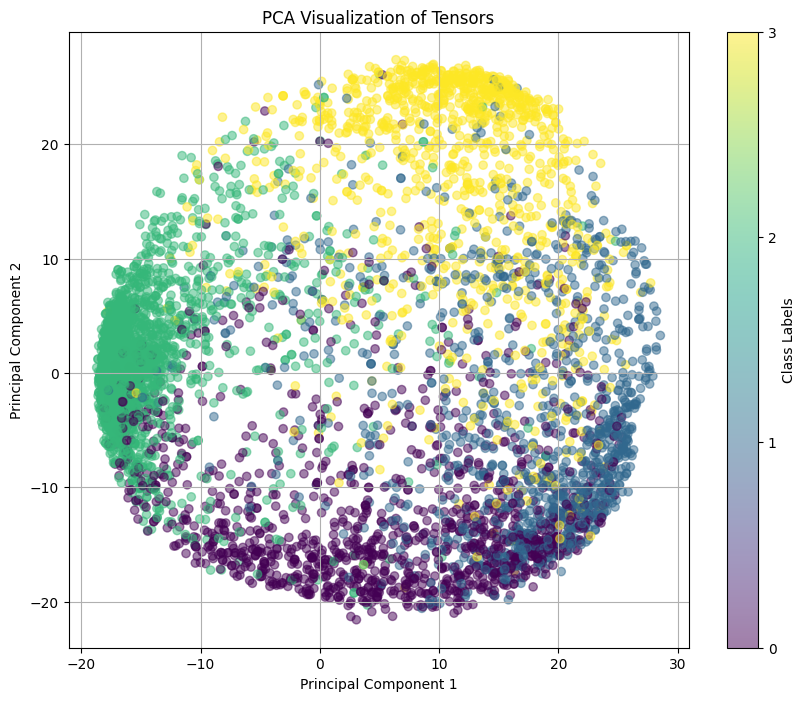

In [56]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
data_np = tensors.numpy()

# 使用 PCA 降维到 2 维
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_np)

# 可视化
plt.figure(figsize=(10, 8))

# 使用 label_def 为不同类别的点标记不同颜色
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=label_def, cmap='viridis', alpha=0.5)

# 添加颜色条
plt.colorbar(scatter, ticks=range(len(set(label_def))), label='Class Labels')

plt.title('PCA Visualization of Tensors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

In [84]:
torch.save(tensors, 'mippi/result/emcodingspace.pt')
with open('mippi/result/label_def.txt', 'w') as file:
    for item in label_def:
        file.write(f"{item}\n")  # Write each integer on a new line

# To load the list back later
with open('mippi/result/label_def.txt', 'r') as file:
    loaded_list = [int(line.strip()) for line in file]

[2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 3, 1, 2, 2, 3, 0, 0, 2, 0, 2, 2, 0, 0, 3, 3, 1, 2, 3, 0, 2, 2, 2, 2, 3, 2, 0, 2, 1, 0, 2, 3, 2, 2, 0, 0, 1, 1, 0, 0, 1, 3, 0, 2, 2, 0, 0, 0, 1, 3, 3, 1, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 3, 0, 0, 2, 2, 2, 0, 3, 2, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 0, 3, 1, 0, 0, 2, 2, 1, 2, 2, 0, 3, 2, 2, 3, 1, 1, 0, 3, 1, 2, 1, 0, 3, 2, 1, 1, 3, 2, 2, 1, 0, 0, 2, 2, 2, 3, 2, 0, 3, 2, 1, 2, 2, 3, 3, 2, 1, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 3, 1, 2, 2, 1, 2, 0, 3, 2, 3, 3, 2, 1, 2, 2, 0, 1, 0, 3, 0, 2, 2, 0, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 3, 1, 3, 0, 2, 1, 2, 2, 0, 3, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 1, 2, 3, 3, 1, 2, 3, 0, 0, 2, 2, 1, 3, 1, 2, 3, 0, 1, 1, 3, 2, 2, 0, 2, 0, 3, 0, 1, 3, 1, 1, 1, 3, 0, 2, 2, 0, 0, 0, 1, 2, 2, 0, 1, 2, 0, 2, 3, 0, 0, 1, 1, 0, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 1, 2, 2, 2, 1, 3, 0, 2, 1, 2, 2, 2, 2, 2, 0, 3, 2, 2, 0, 1, 2, 3, 2, 3, 3, 2, 1, 2, 1, 3, 2, 0, 1, 3, 2, 2, 2, 1, 1, 3, 2, 3, 2, 2, 1, 2, 2, 0, 0, 0, 0, 3, 2, 1, 2, 1, 2, 

In [ ]:
from sklearn.manifold import TSNE
data_np = tensors
# 使用 t-SNE 降维到 2 维
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_np)

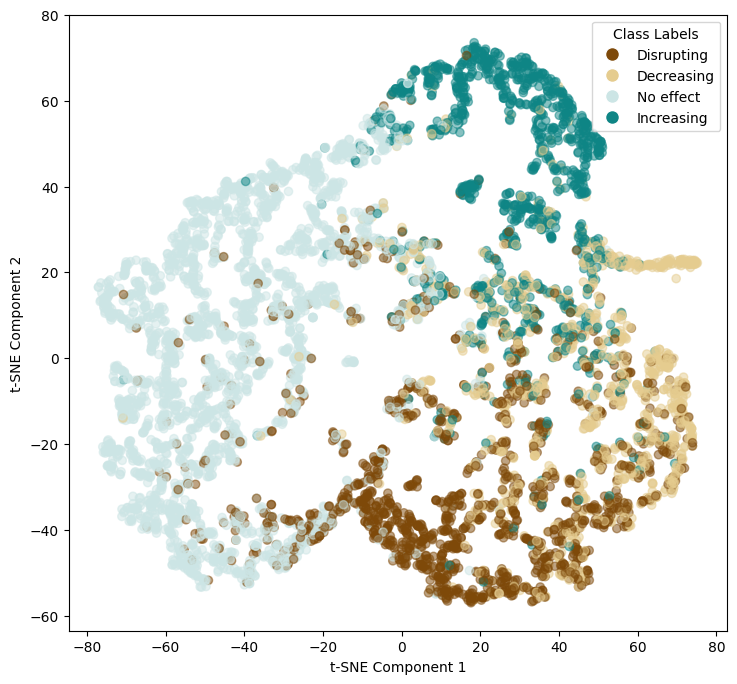

In [50]:
plt.figure(figsize=(8.5, 8))  # Convert cm to inches (1 inch = 2.54 cm)
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_def, cmap='coolwarm', alpha=0.5)

# 自定义颜色映射
scatter.set_array(label_def)
scatter.set_cmap(plt.cm.colors.ListedColormap(['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585']))

# 添加图例
labels = ['Disrupting', 'Decreasing', 'No effect', 'Increasing']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.get_cmap()(i / (len(labels) - 1)), markersize=10) for i in range(len(labels))]
plt.legend(handles, labels, title='Class Labels')

# Remove the color bar line
# plt.colorbar(scatter, ticks=range(len(set(label_def))), label='Class Labels')
# plt.title('Distribution of the test set in the encoding space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(False)  # 去掉网格

# Save the figure with 300 DPI
plt.savefig('manything/photo/tsne_embedding.png', dpi=300, bbox_inches='tight')
plt.show()

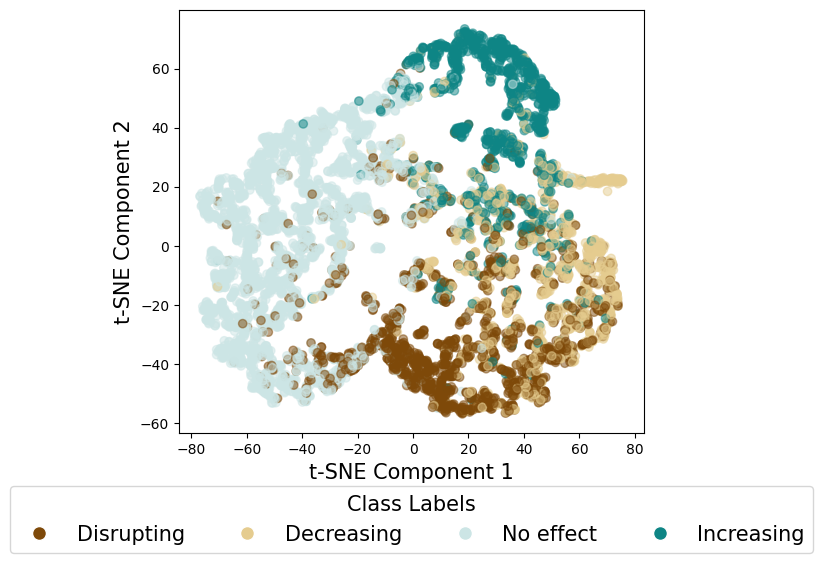

In [110]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(6, 5.5))

# Scatter plot
size_fontsize = 15
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_def, cmap='coolwarm', alpha=0.5)

# Custom color mapping
scatter.set_array(label_def)
scatter.set_cmap(plt.cm.colors.ListedColormap(['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585']))

# Labels and grid
plt.xlabel('t-SNE Component 1', fontsize=size_fontsize)
plt.ylabel('t-SNE Component 2', fontsize=size_fontsize)
plt.grid(False)  # Remove grid

# Create horizontal legend
labels = ['Disrupting', 'Decreasing', 'No effect', 'Increasing']
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.get_cmap()(i / (len(labels) - 1)), markersize=10)
    for i in range(len(labels))
]

# Add legend to the plot
plt.legend(handles, labels, title='Class Labels', fontsize=size_fontsize, title_fontsize=size_fontsize, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

# Save the figure with 300 DPI
plt.savefig('mippi/result/tsne_embedding.png', dpi=300, bbox_inches='tight')
plt.show()

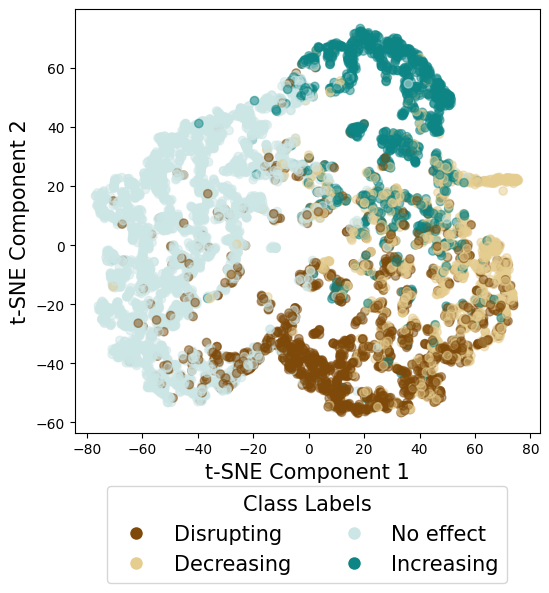

In [111]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(6, 5.5))

# Scatter plot
size_fontsize = 15
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_def, cmap='coolwarm', alpha=0.5)

# Custom color mapping
scatter.set_array(label_def)
scatter.set_cmap(plt.cm.colors.ListedColormap(['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585']))

# Labels and grid
plt.xlabel('t-SNE Component 1', fontsize=size_fontsize)
plt.ylabel('t-SNE Component 2', fontsize=size_fontsize)
plt.grid(False)  # Remove grid

# Create horizontal legend
labels = ['Disrupting', 'Decreasing', 'No effect', 'Increasing']
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.get_cmap()(i / (len(labels) - 1)), markersize=10)
    for i in range(len(labels))
]

# Add legend to the plot with 2 columns
plt.legend(handles, labels, title='Class Labels', fontsize=size_fontsize, title_fontsize=size_fontsize, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Save the figure with 300 DPI
plt.savefig('mippi/result/tsne_embedding.png', dpi=300, bbox_inches='tight')
plt.show()

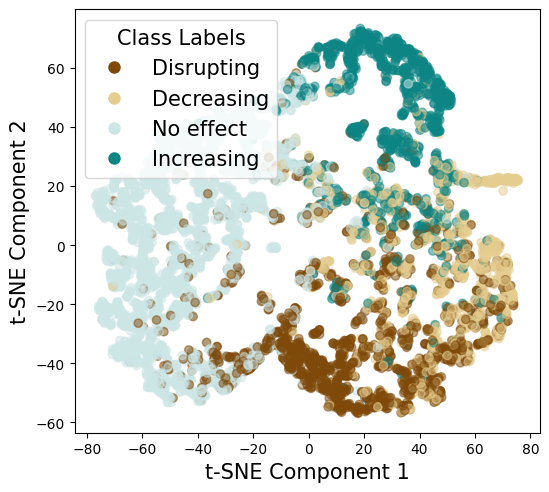

In [107]:
plt.figure(figsize=(6, 5.5))  # Convert cm to inches (1 inch = 2.54 cm)
size_fontsize = 15
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_def, cmap='coolwarm', alpha=0.5)

# 自定义颜色映射
scatter.set_array(label_def)
scatter.set_cmap(plt.cm.colors.ListedColormap(['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585']))

# 添加图例
labels = ['Disrupting', 'Decreasing', 'No effect', 'Increasing']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.get_cmap()(i / (len(labels) - 1)), markersize=10) for i in range(len(labels))]
plt.legend(handles, labels, title='Class Labels', fontsize=size_fontsize, title_fontsize=size_fontsize)

# Remove the color bar line
# plt.colorbar(scatter, ticks=range(len(set(label_def))), label='Class Labels')
# plt.title('Distribution of the test set in the encoding space', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=size_fontsize)
plt.ylabel('t-SNE Component 2', fontsize=size_fontsize)
plt.grid(False)  # 去掉网格

# Save the figure with 300 DPI
plt.savefig('mippi/result/tsne_embedding.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'result' is not defined

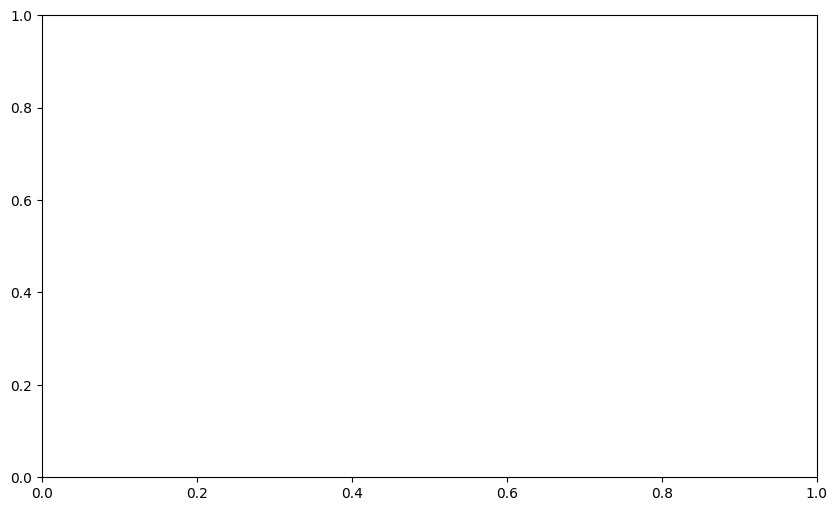

In [ ]:


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 可视化
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_def, cmap='coolwarm', alpha=0.5)

# 自定义颜色映射
scatter.set_array(label_def)
scatter.set_cmap(plt.cm.colors.ListedColormap(['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585']))

# 添加图例
labels = ['Disrupting', 'Decreasing', 'No effect', 'Increasing']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.get_cmap()(i / (len(labels) - 1)), markersize=10) for i in range(len(labels))]
plt.legend(handles, labels, title='Class Labels')

plt.colorbar(scatter, ticks=range(len(set(label_def))), label='Class Labels')
plt.title('Distribution of the test set in the encoding space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(False)  # 去掉网格

# Save the figure to the hard disk
plt.savefig('mippi/result/编码空间分布.png', bbox_inches='tight')  # Save as PNG file
plt.close()  # Close the figure to free memory

In [59]:
import pandas as pd
import math
data_path = 'mippi/processed_mutations.dataset'
df = pd.read_pickle(data_path)
df = df[df['mut0'] != df['mut1']]
new_df1 = df[df['label'] == 1].copy()
new_df1['mut0'], new_df1['mut1'] = new_df1['mut1'], new_df1['mut0']
new_df1['label'] = 3
new_df2 = df[df['label'] == 3].copy()
new_df2['mut0'], new_df2['mut1'] = new_df2['mut1'], new_df2['mut0']
new_df2['label'] = 1

new_df3 = df[df['label'] == 2].copy()
new_df3['mut0'], new_df3['mut1'] = new_df3['mut1'], new_df3['mut0']
new_df3['label'] = 2
df = pd.concat([df, new_df2, new_df3, new_df1], ignore_index=True)
df["position_total"] = df["Feature range(s)"].apply(
    lambda x: sorted(set([int(y.split("-")[0]) for y in x] + [int(y.split("-")[1]) for y in x]))
)
df["position"] = df["position_total"].apply(lambda x: math.ceil((min(x) + max(x)) / 2))
dk = df[df['label'] == 4]
len_half_protein_used =10 

dk = dk[dk["position_total"].apply(lambda x: max(x) - min(x) < 2* len_half_protein_used)]
dk.shape
dk.head()

,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,n_partner,mutAC,mut0,parAC,par0,mut1,label,mutAC1,position_total,position
903,EBI-12509106,[519-520],[NE],[AD],p.Asn519_Glu520delinsAlaAsp,mutation causing(MI:2227),,Q9NZN3,EHD3,,...,2,Q9NZN3,MFSWLGTDDRRRKDPEVFQTVSEGLKKLYKSKLLPLEEHYRFHEFH...,Q9P2R3,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,MFSWLGTDDRRRKDPEVFQTVSEGLKKLYKSKLLPLEEHYRFHEFH...,4,Q9NZN3_Asn519_Glu520delinsAlaAsp,"[519, 520]",520
911,EBI-12509321,[519-519],[N],[A],p.Asn519Ala,mutation causing(MI:2227),,Q9NZN3,EHD3,,...,2,Q9NZN3,MFSWLGTDDRRRKDPEVFQTVSEGLKKLYKSKLLPLEEHYRFHEFH...,Q9P2R3,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,MFSWLGTDDRRRKDPEVFQTVSEGLKKLYKSKLLPLEEHYRFHEFH...,4,Q9NZN3_Asn519Ala,[519],519
913,EBI-12509456,[420-420],[V],[Y],p.Val420Tyr,mutation causing(MI:2227),,Q9P2R3,ANKFY1,,...,2,Q9P2R3,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,Q9NZN3,MFSWLGTDDRRRKDPEVFQTVSEGLKKLYKSKLLPLEEHYRFHEFH...,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,4,Q9P2R3_Val420Tyr,[420],420
943,EBI-12523561,[519-520],[NE],[AD],p.Asn519_Glu520delinsAlaAsp,mutation causing(MI:2227),,Q9NZN3,EHD3,,...,2,Q9NZN3,MFSWLGTDDRRRKDPEVFQTVSEGLKKLYKSKLLPLEEHYRFHEFH...,Q9P2R3,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,MFSWLGTDDRRRKDPEVFQTVSEGLKKLYKSKLLPLEEHYRFHEFH...,4,Q9NZN3_Asn519_Glu520delinsAlaAsp,"[519, 520]",520
944,EBI-12523565,[520-520],[E],[D],p.Glu520Asp,mutation causing(MI:2227),,Q9NZN3,EHD3,,...,2,Q9NZN3,MFSWLGTDDRRRKDPEVFQTVSEGLKKLYKSKLLPLEEHYRFHEFH...,Q9P2R3,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,MFSWLGTDDRRRKDPEVFQTVSEGLKKLYKSKLLPLEEHYRFHEFH...,4,Q9NZN3_Glu520Asp,[520],520


In [56]:
df[df["position_total"].apply(lambda x: max(x) - min(x) < 2* len_half_protein_used)].shape

(22208, 26)

In [59]:
dh = df[df["position_total"].apply(lambda x: max(x) - min(x) < 2* len_half_protein_used)]
print(dh.shape)
dh1 = dh[dh['mut0'].str.len() <= 1500]
dh1 = dh1[dh1['par0'].str.len() <= 1000]
print(dh1.shape)
print(22208 - 18518,1-18518/22208)

(22208, 26)
(18518, 26)
3690 0.1661563400576369


In [62]:
dh1['label'].value_counts(), dh1.shape

(label
 0    6657
 2    6317
 1    4342
 3    1099
 4     103
 Name: count, dtype: int64,
 (18518, 26))

In [63]:
pd.concat([x_train_fold, x_test_fold], ignore_index=True)['label'].value_counts(),pd.concat([x_train_fold, x_test_fold], ignore_index=True)['label'].shape

(label
 2    12634
 0     6657
 1     5441
 3     5441
 Name: count, dtype: int64,
 (30173,))

In [54]:
dk['label'].value_counts()

label
4    125
Name: count, dtype: int64

In [60]:
data_reader = PandasDataReader(dk, batch_size=1, shuffle=True)
label_def_4 = []
pred_def_4 = []
tenss_4 = []
for batch in data_reader:
    predicted_dif, e, ts, atts, att = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
    label_def_4 = label_def_4 + [batch['label']]
    pred_def_4 = pred_def_4 + predicted_dif.tolist()
    tenss_4.append(ts.detach().cpu())
    print_progress_bar(len(pred_def_4), dk.shape[0])
# accuracy_score(pred_def, label_def)
tensors_4 = torch.cat(tenss_4, dim=0)

|████████████████████████████████████████| 100.00% Complete

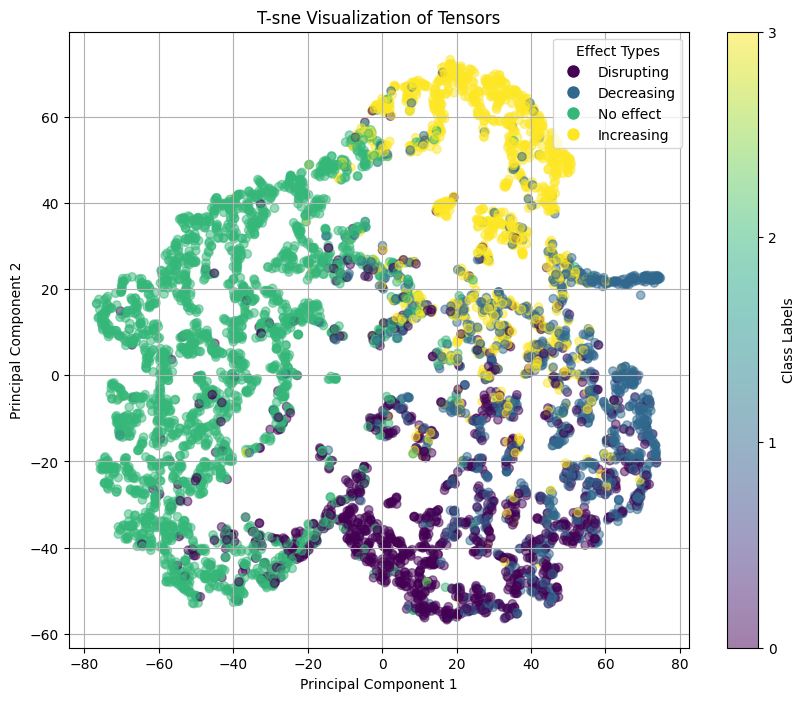

In [62]:
from sklearn.manifold import TSNE
# data_np = torch.cat((tensors, tensors_4),dim = 0).numpy()
data_np = tensors
# 使用 t-SNE 降维到 2 维
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_np)

# 可视化
plt.figure(figsize=(10, 8))

# 使用 label_def 为不同类别的点标记不同颜色
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_def, cmap='viridis', alpha=0.5)

# 添加颜色条
plt.colorbar(scatter, ticks=range(len(set(label_def))), label='Class Labels')

# 自定义类别名称
label_if = ['Disrupting', 'Decreasing', 'No effect', 'Increasing']

# 添加图例
handles = []
for i, label in enumerate(label_if):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10, label=label))

plt.legend(handles=handles, title="Effect Types", loc="upper right")

plt.title('T-sne Visualization of Tensors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

In [35]:
df1 = pd.read_csv('mippi_variation/connect_result.csv')
def process_p2_ires(value):
    # 处理空列表的情况
    if value == '[]':
        return []
    
    # 移除第一个和最后一个字符，并拆分
    elements = value[1:-1].split(',')
    result = []
    
    for element in elements:
        element = element.strip()  # 去除空格
        if '-' in element:  # 如果有范围
            start, end = map(int, element.split('-'))
            result.extend(range(start, end + 1))  # 将范围添加到结果中
        else:
            result.append(int(element))  # 直接添加数字
            
    return result

# 应用函数并创建新列
df1['Processed_P2_IRES'] = df1['P2_IRES'].apply(process_p2_ires)
df1['Processed_P1_IRES'] = df1['P1_IRES'].apply(process_p2_ires)

df1.head()

,Unnamed: 0.1,Unnamed: 0,P1,P2,Source,P1_IRES,P2_IRES,Processed_P2_IRES,Processed_P1_IRES
0,0,0,A0A024R087,Q92560,ECLAIR,[],[],[],[]
1,1,1,A0A024R5S0,O75553,ECLAIR,[],"[56,66,76,107,111,120-121,123-124,132,145,148,...","[56, 66, 76, 107, 111, 120, 121, 123, 124, 132...",[]
2,2,2,A0A024R5S0,P25788,ECLAIR,[],"[7-8,10-11,13-15,17-20,29,55,57-59,122,125-130...","[7, 8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 29,...",[]
3,3,3,A0A024R5S0,Q02446,ECLAIR,[],"[645-648,650-666,668-670]","[645, 646, 647, 648, 650, 651, 652, 653, 654, ...",[]
4,4,4,A0A024R5S0,Q8N9W6,ECLAIR,[],"[33,39,42,54-55,68,70-73,85,87,101-102,104,107...","[33, 39, 42, 54, 55, 68, 70, 71, 72, 73, 85, 8...",[]


In [86]:
nbb = 100
for num in df1['Processed_P2_IRES']:
    for i in num:
        if i < nbb:
            nbb = i
print(nbb)

1


408


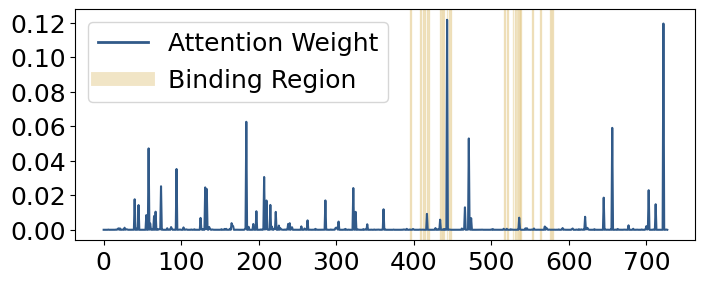

In [ ]:
for i in range(390, len(x_test_fold)):
    batch = x_test_fold.iloc[i]
    # print(df1[(df1['P1'] == batch['parAC']) & (df1['P2'] == batch['mutAC'])]['Processed_P1_IRES'])
    # break
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist() == []:
        continue
    # if len(batch['parAC']) > 120:
    #     continue
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != [] and batch['label'] == 0:
        break
print(i)
import matplotlib.pyplot as plt
attens = []
predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
for attn in attn_backbone:
    attens = [attn[2],attn[1],attn[0]] + attens
attn = attn_neck.squeeze(0).detach()
for i in attens:
    attn = torch.mm(attn, i.squeeze(0)).detach()
# Assuming y is already obtained from your tensor
y = attn[:, 2:-1].squeeze(0).cpu().tolist()
x = range(len(y))

# 创建折线图

import matplotlib.pyplot as plt

# 假设 y 和 x 已经定义
y = attn[:, 2:-1].squeeze(0).cpu().tolist()
x = range(len(y))

# 创建折线图
plt.figure(figsize=(8, 3))
plt.plot(x, y, linestyle='-', color='#315A89', label='attn')  # 设置折线颜色
# plt.plot(x, y, linestyle='-', color='#315A89')  # 设置折线颜色
# 添加标题和标签
# plt.title(f'attn in partner protein')
# plt.xlim(400, 450)

# 添加高亮区域
highlighted_indices = df1[(df1['P2'] == batch['parAC']) & (df1['P1'] == batch['mutAC'])]['Processed_P2_IRES'].tolist()
merged_ranges = []

# 合并连续的索引
for sublist in highlighted_indices:
    current_range = [sublist[0]]
    for i in sublist[1:]:
        if i == current_range[-1] + 1:  # 检查是否连续
            current_range.append(i)
        else:
            merged_ranges.append(current_range)
            current_range = [i]
    merged_ranges.append(current_range)

# 绘制高亮区域
for range_ in merged_ranges:
    plt.axvspan(range_[0] - 0.5, range_[-1] + 0.5, color='#E5CC8F', alpha=0.5)  # 设置高亮区域颜色
# plt.text(-0.1, 1.05, '(a)', transform=plt.gca().transAxes)
# 添加图例

fontsize = 18
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
handles = [
    plt.Line2D([0], [0], color='#315A89', lw=2, label='Attention Weight'),  # Blue line
    plt.Line2D([0], [0], color='#E5CC8F', lw=10, label='Binding Region', alpha=0.5)  # Yellow area
]
plt.legend(handles = handles, fontsize=fontsize)
plt.savefig('manything/photo/attention_all.png', bbox_inches='tight', dpi=300)

# 显示图形
plt.show()

408


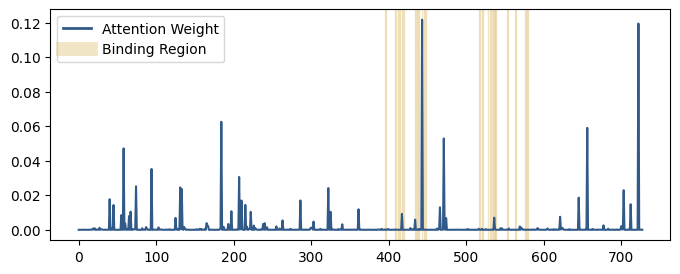

In [51]:
for i in range(400, len(x_test_fold)):
    batch = x_test_fold.iloc[i]
    # print(df1[(df1['P1'] == batch['parAC']) & (df1['P2'] == batch['mutAC'])]['Processed_P1_IRES'])
    # break
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist() == []:
        continue
    # if len(batch['parAC']) > 120:
    #     continue
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != [] and batch['label'] == 0:
        break
print(i)
import matplotlib.pyplot as plt
attens = []
predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
for attn in attn_backbone:
    attens = [attn[2],attn[1],attn[0]] + attens
attn = attn_neck.squeeze(0).detach()
for i in attens:
    attn = torch.mm(attn, i.squeeze(0)).detach()
# Assuming y is already obtained from your tensor
y = attn[:, 2:-1].squeeze(0).cpu().tolist()
x = range(len(y))

# 创建折线图

import matplotlib.pyplot as plt

# 假设 y 和 x 已经定义
y = attn[:, 2:-1].squeeze(0).cpu().tolist()
x = range(len(y))

# 创建折线图
plt.figure(figsize=(8, 3))
plt.plot(x, y, linestyle='-', color='#315A89', label='attn')  # 设置折线颜色
# plt.plot(x, y, linestyle='-', color='#315A89')  # 设置折线颜色
# 添加标题和标签
# plt.title(f'attn in partner protein')
# plt.xlim(400, 450)

# 添加高亮区域
highlighted_indices = df1[(df1['P2'] == batch['parAC']) & (df1['P1'] == batch['mutAC'])]['Processed_P2_IRES'].tolist()
merged_ranges = []

# 合并连续的索引
for sublist in highlighted_indices:
    current_range = [sublist[0]]
    for i in sublist[1:]:
        if i == current_range[-1] + 1:  # 检查是否连续
            current_range.append(i)
        else:
            merged_ranges.append(current_range)
            current_range = [i]
    merged_ranges.append(current_range)

# 绘制高亮区域
for range_ in merged_ranges:
    plt.axvspan(range_[0] - 0.5, range_[-1] + 0.5, color='#E5CC8F', alpha=0.5)  # 设置高亮区域颜色
# plt.text(-0.1, 1.05, '(a)', transform=plt.gca().transAxes)
# 添加图例

fontsize = 10
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
handles = [
    plt.Line2D([0], [0], color='#315A89', lw=2, label='Attention Weight'),  # Blue line
    plt.Line2D([0], [0], color='#E5CC8F', lw=10, label='Binding Region', alpha=0.5)  # Yellow area
]
plt.legend(handles = handles, fontsize=fontsize)
plt.savefig('manything/photo/attention_all.png', bbox_inches='tight', dpi=300)

# 显示图形
plt.show()

In [93]:
batch['parAC'], batch['mutAC']

('Q8TBB1', 'Q8N5M1')

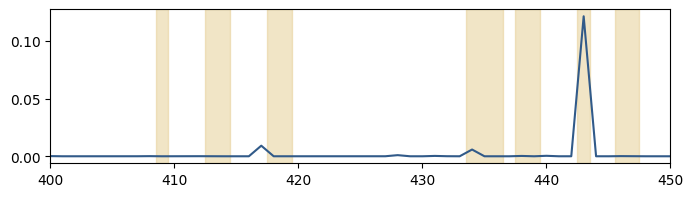

In [52]:
import matplotlib.pyplot as plt

# 创建折线图
plt.figure(figsize=(8, 2))
plt.plot(x, y, linestyle='-', color='#315A89', label='attn')  # 设置折线颜色
plt.xlim(400, 450)

# 添加高亮区域
highlighted_indices = df1[(df1['P2'] == batch['parAC']) & (df1['P1'] == batch['mutAC'])]['Processed_P2_IRES'].tolist()
merged_ranges = []

# 合并连续的索引
for sublist in highlighted_indices:
    current_range = [sublist[0]]
    for i in sublist[1:]:
        if i == current_range[-1] + 1:  # 检查是否连续
            current_range.append(i)
        else:
            merged_ranges.append(current_range)
            current_range = [i]
    merged_ranges.append(current_range)

# 绘制高亮区域
for range_ in merged_ranges:
    plt.axvspan(range_[0] - 0.5, range_[-1] + 0.5, color='#E5CC8F', alpha=0.5)  # 设置高亮区域颜色

# 设置字体大小
fontsize = 10
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# 保存图形
plt.savefig('manything/photo/attention_part.png', bbox_inches='tight', dpi=300)

# 显示图形
plt.show()

18


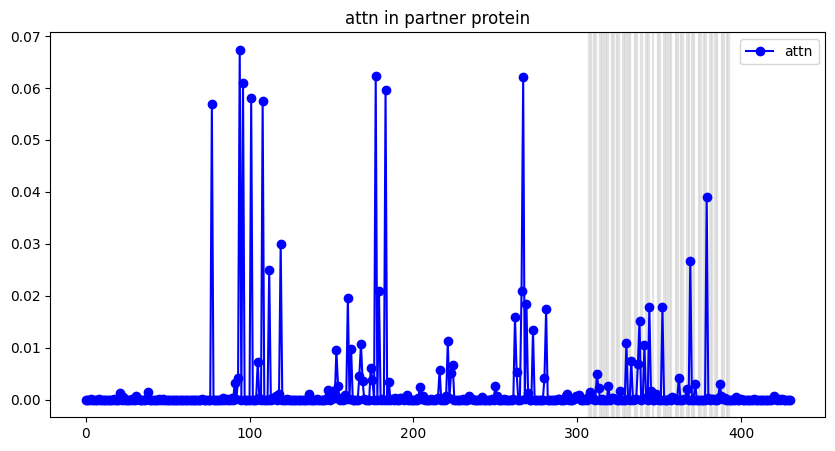

In [85]:
for i in range(18,len(x_test_fold)):
    batch = x_test_fold.iloc[i]
    # print(df1[(df1['P1'] == batch['parAC']) & (df1['P2'] == batch['mutAC'])]['Processed_P1_IRES'])
    # break
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist() == []:
        continue
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != [] and batch['label'] == 0:
        break
print(i)
import matplotlib.pyplot as plt
attens = []
predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
for attn in attn_backbone:
    attens = [attn[2],attn[1],attn[0]] + attens
attn = attn_neck.squeeze(0).detach()
for i in attens:
    attn = torch.mm(attn, i.squeeze(0)).detach()
# Assuming y is already obtained from your tensor
y = attn[:, 2:-1].squeeze(0).cpu().tolist()
x = range(len(y))

# 创建折线图
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='attn')

# 添加标题和标签
plt.title(f'attn in partner protein')

# plt.xlim(300, 400)
# 添加高亮区域
highlighted_indices = df1[(df1['P2'] == batch['parAC']) & (df1['P1'] == batch['mutAC'])]['Processed_P2_IRES'].tolist()

# Flatten the list of lists to a single list
for sublist in highlighted_indices:
    for i in sublist:
        plt.axvspan(i - 1.5, i - 0.5, color='lightgray', alpha=0.5)

# 添加网格
# plt.grid()

# 添加图例
plt.legend()

# 显示图形
plt.show()

In [39]:
labels_connect = []
pred_attns = []
for i in range(len(x_test_fold)):
    batch = x_test_fold.iloc[i]
    # print(df1[(df1['P1'] == batch['parAC']) & (df1['P2'] == batch['mutAC'])]['Processed_P1_IRES'])
    # break
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist() == []:
        continue
    # if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != [] and batch['label'] == 0:
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != []:

        attens = []
        connect_pos = []
        predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
        for attn in attn_backbone:
            attens = [attn[2],attn[1],attn[0]] + attens
        attn = attn_neck.squeeze(0).detach()
        for e in attens:
            attn = torch.mm(attn, e.squeeze(0)).detach()
        # Assuming y is already obtained from your tensor
        y = attn[:, 2:-1].squeeze(0).cpu().tolist()
        highlighted_indices = df1[(df1['P2'] == batch['parAC']) & (df1['P1'] == batch['mutAC'])]['Processed_P2_IRES'].tolist()
        for sublist in highlighted_indices:
            for b in sublist:
                connect_pos.append(b - 1)
        pred_attns.append(y)
        labels_connect.append(connect_pos)
        print_progress_bar(i, len(x_test_fold))

|███████████████████████████████████████-| 98.99% Complete

In [40]:
connect = []
unconnect = []
for num in range(len(pred_attns)):
    attn = pred_attns[num]
    label = labels_connect[num]
    # max_attn = max(my_list)
    for i in range(len(attn)):
        # if attn[i] < max_attn/10:
        #     continue
        if i in label:
            connect.append(attn[i])
        else:
            unconnect.append(attn[i])

In [ ]:
for i in pred_attns:
    print(len(i))
print(len(pred_attns))

In [41]:
connect_b = []
unconnect_b = []
for num in range(len(pred_attns)):
    attn = pred_attns[num]
    label = labels_connect[num]
    max_attn = max(attn)
    for i in range(len(attn)):
        if attn[i] < max_attn/5:
            continue
        if i in label:
            print('hello')
            connect_b.append(attn[i])
        else:
            print('hello')
            unconnect_b.append(attn[i])


hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hell

In [52]:
len(connect), len(unconnect), len(connect_b), len(unconnect_b)

(28157, 453019, 1273, 13713)

In [42]:
list_connection = []
list_unconnection = []
for part_weight in [2,4,8,16,32,64]:
    connect_b = []
    unconnect_b = []
    for num in range(len(pred_attns)):
        attn = pred_attns[num]
        label = labels_connect[num]
        max_attn = max(attn)
        for i in range(len(attn)):
            if attn[i] < max_attn/part_weight:
                continue
            if i in label:
                connect_b.append(attn[i])
            else:
                unconnect_b.append(attn[i])
    list_connection.append(len(connect_b)/len(connect))
    list_unconnection.append(len(unconnect_b)/len(unconnect))

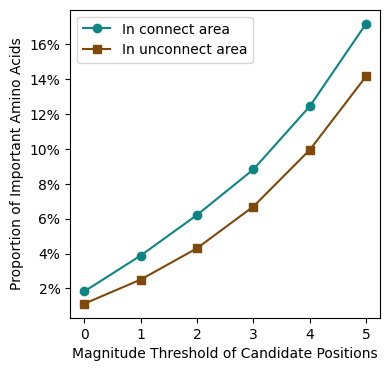

In [43]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def to_percent(y, position):
    return f'{y * 100:.0f}%'

x = range(len(list_connection))
plt.figure(figsize=(4, 4))
# 创建折线图，指定颜色
plt.plot(x, list_connection, marker='o', color='#0E8585', label='In connect area')
plt.plot(x, list_unconnection, marker='s', color='#7E4909', label='In unconnect area')

# 添加标题和标签
# plt.title('Line Plot of Two Lists')
plt.xlabel('Magnitude Threshold of Candidate Positions')
plt.ylabel('Proportion of Important Amino Acids')

# 设置 y 轴为百分比格式
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

# 添加图例
plt.legend()

# 显示图形
plt.show()

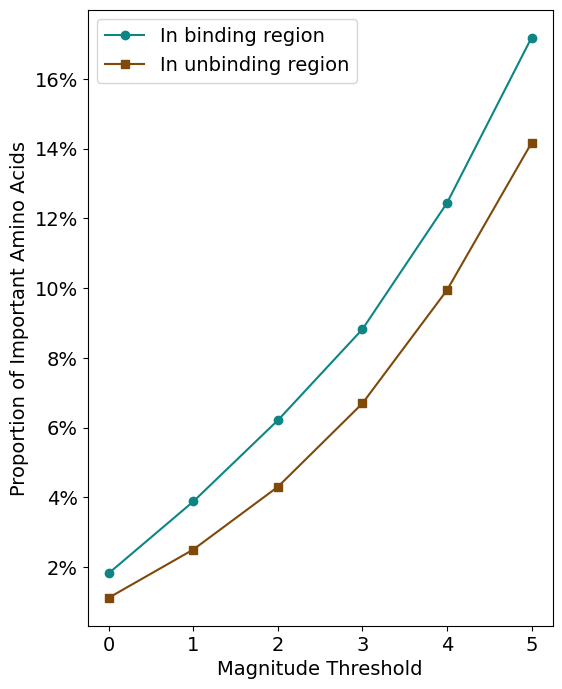

In [50]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    return f'{y * 100:.0f}%'

# Set a base font size
base_font_size = 14

x = range(len(list_connection))
plt.figure(figsize=(6, 8))

# 创建折线图，指定颜色
plt.plot(x, list_connection, marker='o', color='#0E8585', label='In binding region')
plt.plot(x, list_unconnection, marker='s', color='#7E4909', label='In unbinding region')

# 添加标题和标签
plt.xlabel('Magnitude Threshold', fontsize=base_font_size)
plt.ylabel('Proportion of Important Amino Acids', fontsize=base_font_size)

# 设置 y 轴为百分比格式
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

# 设置坐标轴刻度字体大小
plt.xticks(fontsize=base_font_size)
plt.yticks(fontsize=base_font_size)

# 添加图例
plt.legend(fontsize=base_font_size)
plt.savefig('manything/photo/plot_static.png', bbox_inches='tight', dpi=300)
# 显示图形
plt.show()

In [138]:
len(connect_b)/len(connect),len(unconnect_b)/len(unconnect)

(0.04521078239869304, 0.030270253565523743)

In [139]:
import numpy as np
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(connect_b, unconnect_b, alternative='two-sided')

# 输出结果
print(f"U Statistic: {stat}")
print(f"P-Value: {p_value}")

U Statistic: 9278541.0
P-Value: 0.00019425672352258228


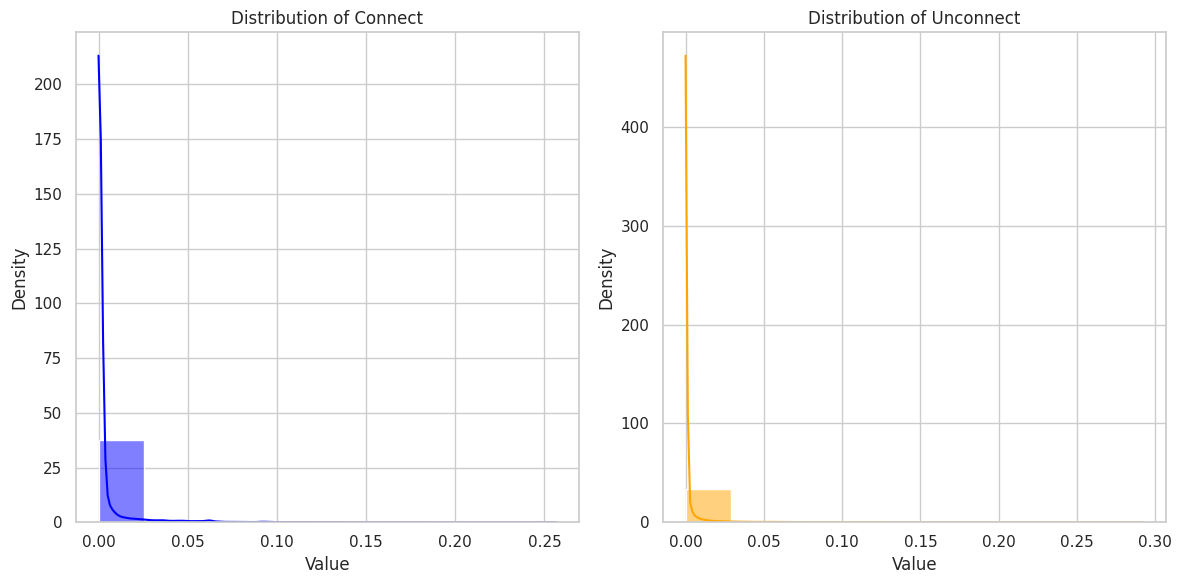

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 设置绘图风格
sns.set(style="whitegrid")

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制 connect 的分布图
plt.subplot(1, 2, 1)
sns.histplot(connect, bins=10, kde=True, color='blue', stat='density')
plt.title('Distribution of Connect')
plt.xlabel('Value')
plt.ylabel('Density')

# 绘制 unconnect 的分布图
plt.subplot(1, 2, 2)
sns.histplot(unconnect, bins=10, kde=True, color='orange', stat='density')
plt.title('Distribution of Unconnect')
plt.xlabel('Value')
plt.ylabel('Density')

# 显示图形
plt.tight_layout()
plt.show()

In [33]:
import ast
use = pd.read_csv('mippi_variation/long_mutation_canuse.csv')
use['Feature range(s)'] = use['Feature range(s)'].apply(ast.literal_eval)
use['Resulting sequence'] = use['Resulting sequence'].apply(ast.literal_eval)
use['Original sequence'] = use['Original sequence'].apply(ast.literal_eval)
use.head()

,Unnamed: 0,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,...,n_partner,mutAC,mut0,parAC,par0,mut1,label,mutAC1,position_total,position
0,29,EBI-10049407,"[18-18, 90-90]","[T, T]","[A, A]",p.[Thr18Ala;Thr90Ala],mutation decreasing rate(MI:1130),NaN,Q06830,PRDX1,...,2,Q06830,MSSGNAKIGHPAPNFKATAVMPDGQFKDISLSDYKGKYVVFFFYPL...,Q13043,METVQLRNPPRRQLKKLDEDSLTKQPEEVFDVLEKLGEGSYGSVYK...,MSSGNAKIGHPAPNFKAAAVMPDGQFKDISLSDYKGKYVVFFFYPL...,1,Q06830_-Thr18Ala_Thr90Ala-,"[18, 90]",54
1,30,EBI-10049410,"[18-18, 90-90, 183-183]","[T, T, T]","[A, A, A]",p.[Thr18Ala;Thr90Ala;Thr183Ala],mutation decreasing rate(MI:1130),NaN,Q06830,PRDX1,...,2,Q06830,MSSGNAKIGHPAPNFKATAVMPDGQFKDISLSDYKGKYVVFFFYPL...,Q13043,METVQLRNPPRRQLKKLDEDSLTKQPEEVFDVLEKLGEGSYGSVYK...,MSSGNAKIGHPAPNFKAAAVMPDGQFKDISLSDYKGKYVVFFFYPL...,1,Q06830_-Thr18Ala_Thr90Ala_Thr183Ala-,"[18, 90, 183]",101
2,31,EBI-10049414,"[18-18, 90-90, 156-156, 183-183]","[T, T, T, T]","[A, A, A, A]",p.[Thr18Ala;Thr90Ala;Thr156Ala;Thr183Ala],mutation decreasing rate(MI:1130),NaN,Q06830,PRDX1,...,2,Q06830,MSSGNAKIGHPAPNFKATAVMPDGQFKDISLSDYKGKYVVFFFYPL...,Q13043,METVQLRNPPRRQLKKLDEDSLTKQPEEVFDVLEKLGEGSYGSVYK...,MSSGNAKIGHPAPNFKAAAVMPDGQFKDISLSDYKGKYVVFFFYPL...,1,Q06830_-Thr18Ala_Thr90Ala_Thr156Ala_Thr183Ala-,"[18, 90, 156, 183]",101
3,32,EBI-10049419,"[18-18, 90-90, 111-111, 183-183]","[T, T, T, T]","[A, A, A, A]",p.[Thr18Ala;Thr90Ala;Thr111Ala;Thr183Ala],mutation decreasing rate(MI:1130),NaN,Q06830,PRDX1,...,2,Q06830,MSSGNAKIGHPAPNFKATAVMPDGQFKDISLSDYKGKYVVFFFYPL...,Q13043,METVQLRNPPRRQLKKLDEDSLTKQPEEVFDVLEKLGEGSYGSVYK...,MSSGNAKIGHPAPNFKAAAVMPDGQFKDISLSDYKGKYVVFFFYPL...,1,Q06830_-Thr18Ala_Thr90Ala_Thr111Ala_Thr183Ala-,"[18, 90, 111, 183]",101
4,97,EBI-10107313,"[24-24, 25-25, 54-54]","[K, Y, D]","[Q, H, H]",p.[Lys24Gln;Tyr25His;Asp54His],mutation decreasing(MI:0119),NaN,Q6IAW1,GABARAP,...,2,Q6IAW1,MKFVYKEEHPFEKRRSEGEKIRKKYPDRVPVIVEKAPKARIGDLDK...,Q8IZQ1,MNMVKRIMGRPRQEECSPQDNALGLMHLRRLFTELCHPPRHMTQKE...,MKFVYKEEHPFEKRRSEGEKIRKQHPDRVPVIVEKAPKARIGDLDK...,1,Q6IAW1_-Lys24Gln_Tyr25His_Asp54His-,"[24, 25, 54]",39


In [186]:
use['label'].value_counts()

label
0    406
1    242
3     70
2     64
4     10
Name: count, dtype: int64

In [36]:
for i in range(18,len(x_test_fold)):
    batch = x_test_fold.iloc[i]
    # print(df1[(df1['P1'] == batch['parAC']) & (df1['P2'] == batch['mutAC'])]['Processed_P1_IRES'])
    # break
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist() == []:
        continue
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != [] and batch['label'] == 0:
        break
print(i)

18


In [37]:

for i in range(len(use)):
    batch = use.iloc[i]

    # print(df1[(df1['P1'] == batch['parAC']) & (df1['P2'] == batch['mutAC'])]['Processed_P1_IRES'])
    # break
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist() == []:
        continue
    # if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != [] and batch['label'] == 0:
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != []:
        lll = []
        positions = batch['Feature range(s)']
        for i in positions:
            lll.append([int(i.split('-')[0]), int(i.split('-')[1])])

        for i in range(len(lll)):
            attens = []
            mut1 = batch["mut0"][:lll[i][0]-1] + batch['Resulting sequence'][i] + batch["mut0"][lll[i][1]:]
            predicted_dif, e, ts, attn_backbone, attn_neck = predict([(lll[i][0]+lll[i][1])//2], [batch["mut0"]], [mut1], [batch["par0"]])
            # predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
            for attn in attn_backbone:
                attens = [attn[2],attn[1],attn[0]] + attens
            attn = attn_neck.squeeze(0).detach()
            for e in attens:
                attn = torch.mm(attn, e.squeeze(0)).detach()
            # Assuming y is already obtained from your tensor
            y = attn[:, 2:-1].squeeze(0).cpu().tolist()
            highlighted_indices = df1[(df1['P2'] == batch['parAC']) & (df1['P1'] == batch['mutAC'])]['Processed_P2_IRES'].tolist()
            print(attn.shape)
            
        break

torch.Size([1, 490])
torch.Size([1, 490])


1
Decreasing


ValueError: Image size of 600x158400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 600x158400 with 792 Axes>

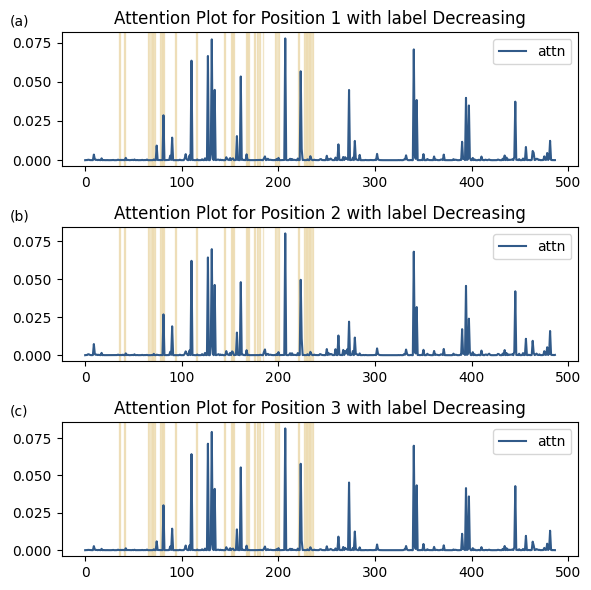

In [83]:
import matplotlib.pyplot as plt
import torch

# Assuming 'use' and 'df1' are defined and populated correctly

# Create a figure for the subplots
num_subplots = len(use)  # Adjust depending on how many plots you want
fig, axs = plt.subplots(num_subplots, 1, figsize=(6, num_subplots * 2))  # Adjust height as needed
label_list = ['Disrupting', 'Decreasing', 'No effect', 'Increasing']
for idx in range(1, len(use)):
    batch = use.iloc[idx]

    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist() == []:
        continue
    
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != []:
        lll = []
        positions = batch['Feature range(s)']
        for i in positions:
            lll.append([int(i.split('-')[0]), int(i.split('-')[1])])

        num_plots = len(lll)  # Number of plots based on the length of lll
        fig, axs = plt.subplots(num_plots, 1, figsize=(6, num_plots * 2))  # Create a figure with vertical subplots
        print(idx)
        print(label_list[int(batch['label'])])
        for i in range(num_plots):
            attens = []
            mut1 = batch["mut0"][:lll[i][0]-1] + batch['Resulting sequence'][i] + batch["mut0"][lll[i][1]:]
            predicted_dif, e, ts, attn_backbone, attn_neck = predict([(lll[i][0]+lll[i][1])//2], [batch["mut0"]], [mut1], [batch["par0"]])
            
            for attn in attn_backbone:
                attens = [attn[2], attn[1], attn[0]] + attens
            
            attn = attn_neck.squeeze(0).detach()
            for e in attens:
                attn = torch.mm(attn, e.squeeze(0)).detach()
            
            # Assuming y is already obtained from your tensor
            y = attn[:, 2:-1].squeeze(0).cpu().tolist()
            x = range(len(y))
        
            # Plotting on the corresponding axes
            axs[i].plot(x, y, linestyle='-', color='#315A89', label='attn')  # Set line color
            
            # Highlighted regions
            highlighted_indices = df1[(df1['P2'] == batch['parAC']) & (df1['P1'] == batch['mutAC'])]['Processed_P2_IRES'].tolist()
            merged_ranges = []
        
            for sublist in highlighted_indices:
                current_range = [sublist[0]]
                for j in sublist[1:]:
                    if j == current_range[-1] + 1:  # Check if continuous
                        current_range.append(j)
                    else:
                        merged_ranges.append(current_range)
                        current_range = [j]
                merged_ranges.append(current_range)
            
            # Draw highlighted regions
            for range_ in merged_ranges:
                axs[i].axvspan(range_[0] - 0.5, range_[-1] + 0.5, color='#E5CC8F', alpha=0.5)  # Set highlight color
            
            axs[i].text(-0.1, 1.05, f'({chr(97 + i)})', transform=axs[i].transAxes)  # Label for each subplot
            axs[i].legend()
            axs[i].set_title(f'Attention Plot for Position {i + 1} with label {label_list[predicted_dif.item()]}')  # Optional title for each subplot

        # Adjust layout
        break
plt.savefig('multi-point_mutation.jpg', )
plt.tight_layout()
plt.show()


In [198]:
predicted_dif.item()

2

In [ ]:
results_final = []
for num in range(use.shape[0]):
    batch = use.iloc[num]
    positions = batch['Feature range(s)']
    lll = []
    for i in positions:
        lll.append([int(i.split('-')[0]), int(i.split('-')[1])])
    results = []
    vectors= []
    for i in range(len(lll)):
        mut1 = batch["mut0"][:lll[i][0]-1] + batch['Resulting sequence'][i] + batch["mut0"][lll[i][1]:]
        predicted_dif, e, ts, attn_backbone, attn_neck = predict([(lll[i][0]+lll[i][1])//2], [batch["mut0"]], [mut1], [batch["par0"]])
        results.append(predicted_dif.item())
        vectors.append(e.detach())
    results_final.append([results, vectors])
    print(num)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


In [148]:
len(results_final)

792

In [147]:
check = 9
print(results_final[check][0])
for i in results_final[check][1]:
    print(i.tolist())
print(use.iloc[check]['label'])

[1, 1]
[[1.0970075130462646, 3.4621334075927734, -4.11228084564209, -0.8091763257980347]]
[[1.206138014793396, 3.4794867038726807, -3.9907419681549072, -0.9877091646194458]]
0


In [107]:
for check in range(len(results_final)):
    print(results_final[check][0], use.iloc[check]['label'])

[1, 1] 1
[1, 1, 1] 1
[1, 1, 1, 1] 1
[1, 1, 1, 1] 1
[0, 0, 0] 1
[0, 0, 0] 0
[2, 2, 0] 3
[2, 2, 0] 3
[0, 2, 0, 0, 0, 1, 0] 1
[1, 1] 0
[1, 1] 1
[1, 1] 1
[0, 0] 1
[0, 0] 1
[0, 0] 0
[0, 0] 1
[0, 0] 1
[0, 0] 1
[0, 0] 1
[0, 0] 1
[3, 0] 0
[0, 0] 1
[1, 0] 1
[0, 0] 1
[0, 0] 1
[0, 0] 0
[1, 1, 1] 0
[1, 1, 1] 0
[1, 1, 1] 0
[2, 1, 3, 0, 1, 0, 0] 3
[2, 2, 0] 3
[1, 0, 0, 1, 0, 3, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1] 3
[2, 0, 0] 1
[0, 1, 1, 1] 0
[1, 1, 0, 1] 0
[0, 0] 1
[1, 1] 1
[1, 1] 1
[0, 0, 2] 0
[2, 2, 0] 3
[0, 2, 2, 2, 2, 0] 1
[2, 1, 0, 3, 0, 2] 1
[0, 1, 1, 1] 0
[1, 1, 1, 0, 1, 1] 0
[0, 0, 0, 0, 0, 0] 0
[0, 0, 2, 0, 0, 2] 0
[1, 1, 0] 1
[0, 1, 1] 1
[0, 0, 0] 0
[0, 0, 0] 0
[3, 1] 2
[1, 3] 2
[3, 1] 2
[3, 1] 1
[3, 1] 0
[3, 1] 2
[2, 2, 2] 4
[2, 2, 2] 4
[1, 1, 1, 1] 0
[1, 2, 2] 0
[1, 0] 0
[1, 1, 1, 1, 1, 1] 0
[3, 1] 3
[0, 0, 0, 0] 0
[1, 1, 1, 1] 0
[0, 0] 0
[1, 1] 0
[1, 1] 0
[0, 2] 2
[1, 1, 1, 2, 0] 0
[1, 1, 2, 2, 2] 0
[1, 1, 1, 1] 0
[3, 3] 3
[3, 1, 3] 1
[3, 1] 1
[1, 0] 1
[0, 1] 1
[1, 1] 1
[

In [108]:
data = {
    'label': [use.iloc[check]['label'] for check in range(len(use))],
    'results': [results_final[check][0] for check in range(len(results_final))]
}

results_df = pd.DataFrame(data)
results_df.head()

,label,results
0,1,"[1, 1]"
1,1,"[1, 1, 1]"
2,1,"[1, 1, 1, 1]"
3,1,"[1, 1, 1, 1]"
4,1,"[0, 0, 0]"


In [109]:
results_df.to_csv('long_range_mutations.csv')

In [110]:
multis = x_test_fold[x_test_fold['Feature range(s)'].str.contains(',', na=False)]
print(multis.shape)
multis.head()

(361, 27)


,Unnamed: 0,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,...,n_partner,mutAC,mut0,parAC,par0,mut1,label,mutAC1,position_total,position
45,353,EBI-10814275,"['191-191', '193-193', '188-188']","['K', 'K', 'K']","['A', 'A', 'A']",p.[Lys188Ala;Lys191Ala;Lys193Ala],mutation disrupting strength(MI:1128),NaN,O70468,Mybpc3,...,2,O70468,MPEPGKKPVSAFNKKPRSAEVTAGSAAVFEAETERSGVMVRWQRDG...,P68033,MCDDEETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,MPEPGKKPVSAFNKKPRSAEVTAGSAAVFEAETERSGVMVRWQRDG...,0,O70468_-Lys188Ala_Lys191Ala_Lys193Ala-,"[188, 191, 193]",191
48,377,EBI-10819950,"['1056-1056', '1059-1059']","['P', 'P']","['A', 'A']",p.[Pro1056Ala;Pro1059Ala],mutation disrupting(MI:0573),NaN,O43295,SRGAP3,...,2,O43295,MSSQTKFKKDKEIIAEYEAQIKEIRTQLVEQFKCLEQQSESRLQLL...,O08838,MADIKTGIFAKNVQKRLNRAQEKVLQKLGKADETKDEQFEEYVQNF...,MSSQTKFKKDKEIIAEYEAQIKEIRTQLVEQFKCLEQQSESRLQLL...,0,O43295_-Pro1056Ala_Pro1059Ala-,"[1056, 1059]",1058
49,378,EBI-10819962,"['1056-1056', '1059-1059']","['P', 'P']","['A', 'A']",p.[Pro1056Ala;Pro1059Ala],mutation disrupting(MI:0573),NaN,O43295,SRGAP3,...,2,O43295,MSSQTKFKKDKEIIAEYEAQIKEIRTQLVEQFKCLEQQSESRLQLL...,P62993,MEAIAKYDFKATADDELSFKRGDILKVLNEECDQNWYKAELNGKDG...,MSSQTKFKKDKEIIAEYEAQIKEIRTQLVEQFKCLEQQSESRLQLL...,0,O43295_-Pro1056Ala_Pro1059Ala-,"[1056, 1059]",1058
54,397,EBI-10889842,"['92-92', '99-99', '106-106']","['L', 'L', 'L']","['A', 'A', 'A']",p.[Leu92Ala;Leu99Ala;Leu106Ala],mutation decreasing(MI:0119),NaN,Q77Q71,R-LORF7,...,2,Q77Q71,MSQEPEPGAMPYSPADDPSPLDLSLGSTSRRKKRKSHDIPNSPSKH...,P18870,MSAKMEPTFYEDALNASFAPPESGGYGYNNAKVLKQSMTLNLSDAA...,MSQEPEPGAMPYSPADDPSPLDLSLGSTSRRKKRKSHDIPNSPSKH...,1,Q77Q71_-Leu92Ala_Leu99Ala_Leu106Ala-,"[92, 99, 106]",99
66,446,EBI-10904602,"['151-151', '155-155']","['T', 'S']","['A', 'A']",p.[Thr151Ala;Ser155Ala],mutation disrupting rate(MI:1129),NaN,O75952-3,CABYR,...,2,O75952,MISSKPRLVVPYGLKTLLEGISRAVLKTNPSNINQFAAAYFQELTM...,P49841,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,MISSKPRLVVPYGLKTLLEGISRAVLKTNPSNINQFAAAYFQELTM...,0,O75952_-Thr151Ala_Ser155Ala-,"[151, 155]",153


In [112]:
data_reader = PandasDataReader(multis, batch_size=1, shuffle=True)
label_def_2 = []
pred_def_2 = []
for batch in data_reader:
    # if len(batch["mut0"]) > 2*len_half_protein_used:
    #     continue
    predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
    label_def_2 = label_def_2 + [batch['label']]
    pred_def_2 = pred_def_2 + predicted_dif.tolist()

    print_progress_bar(len(pred_def_2), multis.shape[0])
accuracy_score(pred_def_2, label_def_2)

|████████████████████████████████████████| 100.00% Complete

0.6703601108033241

In [113]:
from sklearn.metrics import classification_report
report = classification_report(label_def_2, pred_def_2, target_names=['Disrupting', 'Decreasing', 'No effect', 'Increasing'], output_dict=True)

# 格式化输出
report_df = pd.DataFrame(report).transpose()

# 格式化 Precision, Recall 和 F1-score，保留四位有效数字
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.4f}")
report_df.to_csv('mippi/result/短距离多突变测试集.csv')
# 打印结果
print(report_df)

             precision  recall f1-score    support
Disrupting      0.7912  0.5760   0.6667  125.00000
Decreasing      0.5634  0.7080   0.6275  113.00000
No effect       0.5476  0.7931   0.6479   29.00000
Increasing      0.7791  0.7128   0.7444   94.00000
accuracy        0.6704  0.6704   0.6704    0.67036
macro avg       0.6703  0.6975   0.6716  361.00000
weighted avg    0.6972  0.6704   0.6731  361.00000


In [154]:
for i in range(20,len(x_test_fold)):
    batch = x_test_fold.iloc[i]
    # print(df1[(df1['P1'] == batch['parAC']) & (df1['P2'] == batch['mutAC'])]['Processed_P1_IRES'])
    # break
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist() == []:
        continue
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != [] and batch['label'] == 0 and len(batch['par0']) < 150:
        break
print(i)
import matplotlib.pyplot as plt
attens = []
predicted_dif, e, ts, attn_backbone, attn_neck = predict([batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]])
for attn in attn_backbone:
    attens = [attn[2],attn[1],attn[0]] + attens
# attn = attn_neck.squeeze(0).detach()
attn = attens[0].squeeze(0)
for i in attens[1:-1]:
    attn = torch.mm(attn, i.squeeze(0)).detach()

len(batch['par0']),attn[2:-1].shape

257


(136, torch.Size([136, 42]))

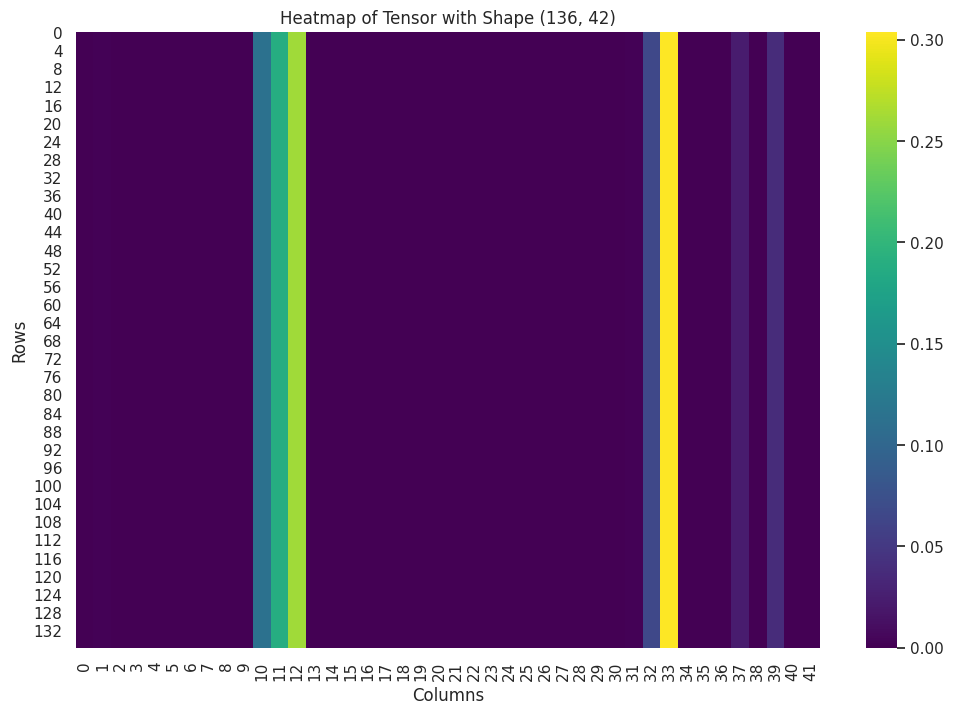

In [156]:
# 将张量转换为 NumPy 数组
data_np = attn[2:-1].detach().cpu().numpy()

# 创建热图
plt.figure(figsize=(12, 8))
sns.heatmap(data_np, cmap='viridis')

# 添加标题
plt.title('Heatmap of Tensor with Shape (136, 42)')
plt.xlabel('Columns')
plt.ylabel('Rows')

# 显示热图
plt.show()

102
Disrupting
201


ValueError: Image size of 600x158400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 600x158400 with 792 Axes>

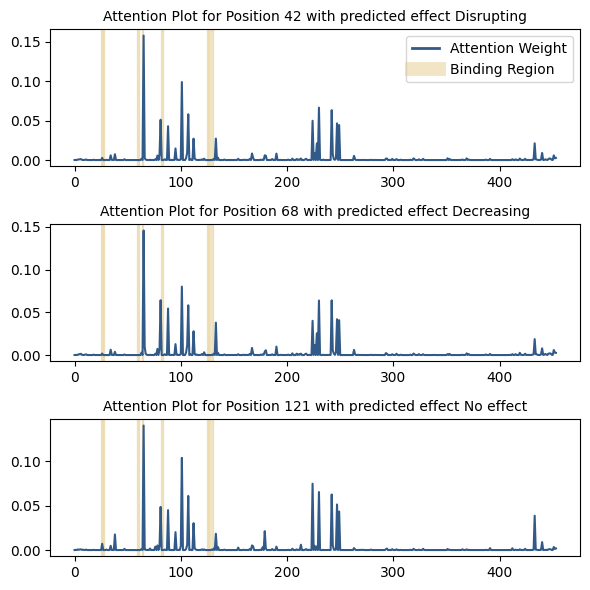

In [38]:
import matplotlib.pyplot as plt
import torch

# Assuming 'use' and 'df1' are defined and populated correctly

# Create a figure for the subplots
num_subplots = len(use)  # Adjust depending on how many plots you want
fig, axs = plt.subplots(num_subplots, 1, figsize=(6, num_subplots * 2))  # Adjust height as needed
label_list = ['Disrupting', 'Decreasing', 'No effect', 'Increasing']
for idx in range(102, len(use)):
    batch = use.iloc[idx]

    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist() == []:
        continue
    
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != []:
        lll = []
        positions = batch['Feature range(s)']
        for i in positions:
            lll.append([int(i.split('-')[0]), int(i.split('-')[1])])

        num_plots = len(lll)  # Number of plots based on the length of lll
        fig, axs = plt.subplots(num_plots, 1, figsize=(6, num_plots * 2))  # Create a figure with vertical subplots
        print(idx)
        print(label_list[int(batch['label'])])
        print(len(batch['mut0']))
        for i in range(num_plots):
            attens = []
            mut1 = batch["mut0"][:lll[i][0]-1] + batch['Resulting sequence'][i] + batch["mut0"][lll[i][1]:]
            predicted_dif, e, ts, attn_backbone, attn_neck = predict([(lll[i][0]+lll[i][1])//2], [batch["mut0"]], [mut1], [batch["par0"]])
            
            for attn in attn_backbone:
                attens = [attn[2], attn[1], attn[0]] + attens
            
            attn = attn_neck.squeeze(0).detach()
            for e in attens:
                attn = torch.mm(attn, e.squeeze(0)).detach()
            
            # Assuming y is already obtained from your tensor
            y = attn[:, 2:-1].squeeze(0).cpu().tolist()
            x = range(len(y))

            # Plotting on the corresponding axes
            axs[i].plot(x, y, linestyle='-', color='#315A89', label='Attention Weight')  # Set line color
            
            # Highlighted regions
            highlighted_indices = df1[(df1['P2'] == batch['parAC']) & (df1['P1'] == batch['mutAC'])]['Processed_P2_IRES'].tolist()
            merged_ranges = []

            for sublist in highlighted_indices:
                current_range = [sublist[0]]
                for j in sublist[1:]:
                    if j == current_range[-1] + 1:  # Check if continuous
                        current_range.append(j)
                    else:
                        merged_ranges.append(current_range)
                        current_range = [j]
                merged_ranges.append(current_range)
            
            # Draw highlighted regions
            for range_ in merged_ranges:
                axs[i].axvspan(range_[0] - 0.5, range_[-1] + 0.5, color='#E5CC8F', alpha=0.5)  # Set highlight color
            # if i != 0 :
            #     axs[i].legend().set_visible(False) 
            # Remove the line that adds subplot labels
            # axs[i].text(-0.1, 1.05, f'({chr(97 + i)})', transform=axs[i].transAxes)  # Label for each subplot
            # axs[i].set_xlim(0, 150)
            handles = [
                plt.Line2D([0], [0], color='#315A89', lw=2, label='Attention Weight'),  # Blue line
                plt.Line2D([0], [0], color='#E5CC8F', lw=10, label='Binding Region', alpha=0.5)  # Yellow area
            ]
            if i == 0 :
                axs[i].legend(handles = handles)
            axs[i].set_title(f'Attention Plot for Position {(lll[i][0]+lll[i][1])//2} with predicted effect {label_list[predicted_dif.item()]}', fontsize=10)  # Optional title for each subplot
            # Adjust layout
        break
plt.subplots_adjust(hspace=0.5)
plt.savefig('manything/multi-point_mutation.png',dpi = 1000)
plt.tight_layout()
plt.show()

In [113]:
plt.savefig('multi-point_mutation.jpg', dpi=300)

<Figure size 640x480 with 0 Axes>

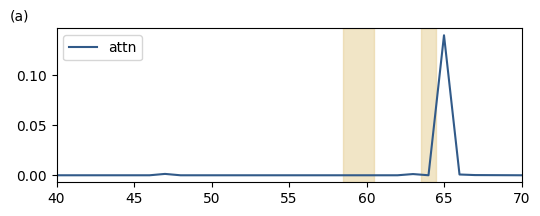

In [ ]:
plt.figure(figsize=(6, 2))
plt.plot(x, y, linestyle='-', color='#315A89', label='attn')  # 设置折线颜色
# plt.plot(x, y, linestyle='-', color='#315A89')  # 设置折线颜色
# 添加标题和标签
# plt.title(f'attn in partner protein')
# plt.xlim(40, 70)

# 添加高亮区域
highlighted_indices = df1[(df1['P2'] == batch['parAC']) & (df1['P1'] == batch['mutAC'])]['Processed_P2_IRES'].tolist()
merged_ranges = []

# 合并连续的索引
for sublist in highlighted_indices:
    current_range = [sublist[0]]
    for i in sublist[1:]:
        if i == current_range[-1] + 1:  # 检查是否连续
            current_range.append(i)
        else:
            merged_ranges.append(current_range)
            current_range = [i]
    merged_ranges.append(current_range)

# 绘制高亮区域
for range_ in merged_ranges:
    plt.axvspan(range_[0] - 0.5, range_[-1] + 0.5, color='#E5CC8F', alpha=0.5)  # 设置高亮区域颜色
plt.text(-0.1, 1.05, '(a)', transform=plt.gca().transAxes)
# 添加图例
plt.legend()

# 显示图形
plt.show()

In [72]:
len(batch["mut0"])

201

102
Disrupting
201


ValueError: Image size of 600x158400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 600x158400 with 792 Axes>

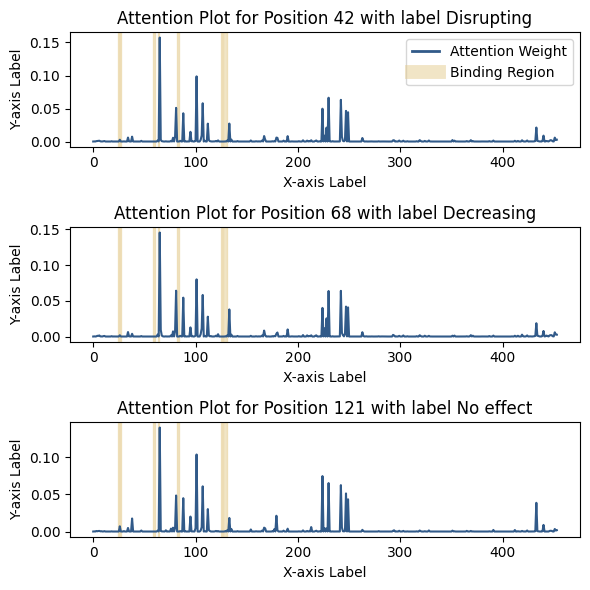

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming 'use' and 'df1' are defined and populated correctly

# Create a figure for the subplots
num_subplots = len(use)  # Adjust depending on how many plots you want
fig, axs = plt.subplots(num_subplots, 1, figsize=(6, num_subplots * 2))  # Adjust height as needed
label_list = ['Disrupting', 'Decreasing', 'No effect', 'Increasing']
for idx in range(102, len(use)):
    batch = use.iloc[idx]

    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist() == []:
        continue
    
    if df1[(df1['P1'] == batch['mutAC']) & (df1['P2'] == batch['parAC'])]['Processed_P2_IRES'].tolist()[0] != []:
        lll = []
        positions = batch['Feature range(s)']
        for i in positions:
            lll.append([int(i.split('-')[0]), int(i.split('-')[1])])

        num_plots = len(lll)  # Number of plots based on the length of lll
        fig, axs = plt.subplots(num_plots, 1, figsize=(6, num_plots * 2))  # Create a figure with vertical subplots
        print(idx)
        print(label_list[int(batch['label'])])
        print(len(batch['mut0']))
        for i in range(num_plots):
            attens = []
            mut1 = batch["mut0"][:lll[i][0]-1] + batch['Resulting sequence'][i] + batch["mut0"][lll[i][1]:]
            predicted_dif, e, ts, attn_backbone, attn_neck = predict([(lll[i][0]+lll[i][1])//2], [batch["mut0"]], [mut1], [batch["par0"]])
            
            for attn in attn_backbone:
                attens = [attn[2], attn[1], attn[0]] + attens
            
            attn = attn_neck.squeeze(0).detach()
            for e in attens:
                attn = torch.mm(attn, e.squeeze(0)).detach()
            
            # Assuming y is already obtained from your tensor
            y = attn[:, 2:-1].squeeze(0).cpu().tolist()
            x = range(len(y))

            # Plotting on the corresponding axes
            axs[i].plot(x, y, linestyle='-', color='#315A89', label='Attention Weight')  # Set line color
            
            # Highlighted regions
            highlighted_indices = df1[(df1['P2'] == batch['parAC']) & (df1['P1'] == batch['mutAC'])]['Processed_P2_IRES'].tolist()
            merged_ranges = []

            for sublist in highlighted_indices:
                current_range = [sublist[0]]
                for j in sublist[1:]:
                    if j == current_range[-1] + 1:  # Check if continuous
                        current_range.append(j)
                    else:
                        merged_ranges.append(current_range)
                        current_range = [j]
                merged_ranges.append(current_range)
            
            # Draw highlighted regions
            for range_ in merged_ranges:
                axs[i].axvspan(range_[0] - 0.5, range_[-1] + 0.5, color='#E5CC8F', alpha=0.5)  # Set highlight color
            
            # Create custom legend
            handles = [
                plt.Line2D([0], [0], color='#315A89', lw=2, label='Attention Weight'),  # Blue line
                plt.Line2D([0], [0], color='#E5CC8F', lw=10, label='Binding Region', alpha=0.5)  # Yellow area
            ]
            if i == 0:
                axs[i].legend(handles=handles, fontsize=10)  # Set legend font size
            axs[i].set_title(f'Attention Plot for Position {(lll[i][0]+lll[i][1])//2} with predicted effect {label_list[predicted_dif.item()]}', fontsize=12)  # Set title font size
            # axs[i].set_xlim(50, 100)
            # Set x and y axis labels font size
            # axs[i].set_xlabel('X-axis Label', fontsize=10)  # Adjust as needed
            axs[i].set_ylabel('Y-axis Label', fontsize=10)  # Adjust as needed
            
            # Adjust layout
        break

plt.savefig('manything/photo/multi-point_mutation.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [68]:
#/data_8/lyk/data/skempi2_window_with_pssm.dataset
import pandas as pd

# 读取数据集
file_path = 'data/skempi2_window_with_pssm.dataset'
dfl = pd.read_pickle('data/skempi2_window_with_pssm.dataset')
dfl = dfl.loc[:, ~dfl.columns.str.contains('pssm|51')]

# 查看数据框的前几行
dfl.head()

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,...,parchain_s,ori_seq,mut_seq,par_seq,pos1_w,ori_win,mut_win,mutAC,oriAC,parAC
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,Pr/PI,5.26E-11,5.260000e-11,1.12E-12,1.120000e-12,...,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTGDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38G,1CSE_E_I_I,1CSE_E_I_E
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,Pr/PI,8.33E-12,8.330000e-12,1.12E-12,1.120000e-12,...,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTSDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38S,1CSE_E_I_I,1CSE_E_I_E
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,Pr/PI,1.02E-07,1.020000e-07,1.12E-12,1.120000e-12,...,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTPDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38P,1CSE_E_I_I,1CSE_E_I_E
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,Pr/PI,1.72E-10,1.720000e-10,1.12E-12,1.120000e-12,...,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTIDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38I,1CSE_E_I_I,1CSE_E_I_E
4,1CSE_E_I,LI45D,LI38D,COR,Pr/PI,Pr/PI,1.92E-09,1.920000e-09,1.12E-12,1.120000e-12,...,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTDDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38D,1CSE_E_I_I,1CSE_E_I_E


In [35]:
batch = dfl.iloc[0]
batch['ori_seq'][batch['pos1_w']-1] != batch['mut_seq'][batch['pos1_w']-1]

True

In [36]:
mask = dfl.apply(lambda row: row['ori_seq'][row['pos1_w'] - 1] != row['mut_seq'][row['pos1_w'] - 1], axis=1)

# 筛选符合条件的行
filtered_df = dfl[mask]

# 查看新 DataFrame 的前几行
print(filtered_df.shape)

(2950, 49)


In [37]:
filtered_df['pred'] = 5
filtered_df.head()

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,...,ori_seq,mut_seq,par_seq,pos1_w,ori_win,mut_win,mutAC,oriAC,parAC,pred
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,Pr/PI,5.26E-11,5.260000e-11,1.12E-12,1.120000e-12,...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTGDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38G,1CSE_E_I_I,1CSE_E_I_E,5
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,Pr/PI,8.33E-12,8.330000e-12,1.12E-12,1.120000e-12,...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTSDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38S,1CSE_E_I_I,1CSE_E_I_E,5
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,Pr/PI,1.02E-07,1.020000e-07,1.12E-12,1.120000e-12,...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTPDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38P,1CSE_E_I_I,1CSE_E_I_E,5
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,Pr/PI,1.72E-10,1.720000e-10,1.12E-12,1.120000e-12,...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTIDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38I,1CSE_E_I_I,1CSE_E_I_E,5
4,1CSE_E_I,LI45D,LI38D,COR,Pr/PI,Pr/PI,1.92E-09,1.920000e-09,1.12E-12,1.120000e-12,...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTDDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38D,1CSE_E_I_I,1CSE_E_I_E,5


In [69]:
label_ddg = []
pred_ddg = []
# a,b,c,d = [batch["position"]], [batch["mut0"]], [batch["mut1"]], [batch["par0"]]
# predicted_dif = predict(a,b,c,d)
# mut0,mut0_mask = esm_model.encode(['VSFRYIFGLPPLILVLLPVASSDCDIEGKDGKQYE','PPLILVLLPVASSDCDIEGKDGK'])
# predict([5], ['VSFRYIFGLPPLILVLLPVASSDCDIEGKDGKQYE'], ['VSFRRIFGLPPLILVLLPVASSDCDIEGKDGKQYE'], ['PPLILVLLPVASSDCDIEGKDGK'])
data_reader = PandasDataReader(filtered_df, batch_size=1, shuffle=True)
for batch in data_reader:
    # if len(batch["mut0"]) > 2*len_half_protein_used:
    #     continue
    predicted_dif, _, _, _, _ = predict([batch["pos1_w"]], [batch["ori_seq"]], [batch["mut_seq"]], [batch["par_seq"]])
    label_ddg = label_ddg + [batch['ddg']]
    pred_ddg = pred_ddg + predicted_dif.tolist()
    # tss.append(ts.detach().cpu())
    print_progress_bar(len(pred_ddg), filtered_df.shape[0])
    # tensors = torch.cat(tss, dim = 0)
# accuracy_score(pred_def, label_def)

|████████████████████████████████████████| 100.00% Complete

In [144]:
len(label_ddg), len(pred_ddg)

(2950, 2950)

In [145]:
label_ddg[:5], pred_ddg[:5]

([0.05643829655787785,
  1.0870618351929116,
  1.4840320759073873,
  -0.2844508562903559,
  -0.1682866516901357],
 [1, 3, 2, 3, 0])

/tmp/ipykernel_104456/2784339809.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='pred_ddg', y='label_ddg', data=data, palette=['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585'])


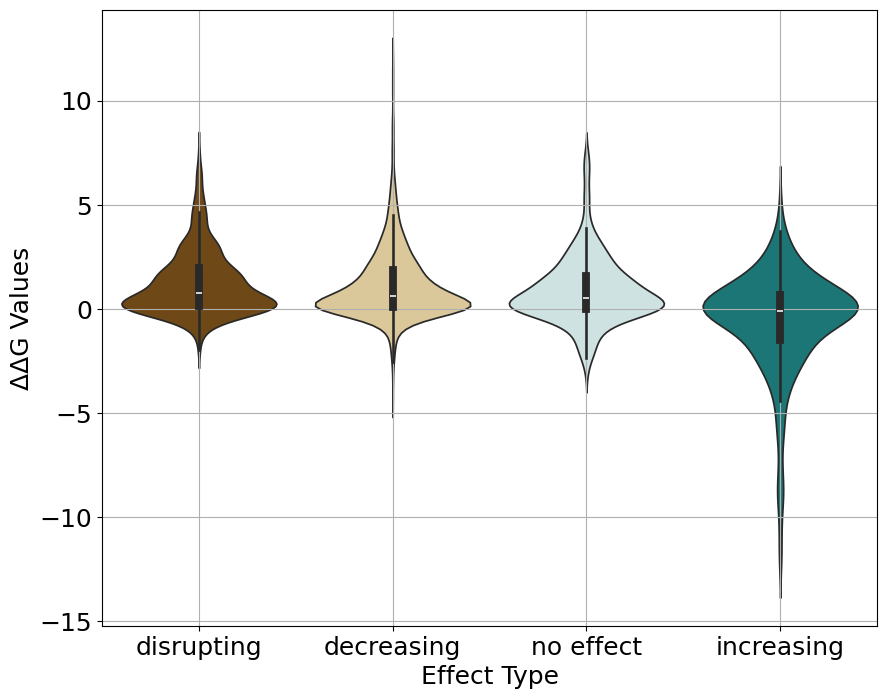

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 label_ddg 和 pred_ddg 已经定义
data = pd.DataFrame({
    'label_ddg': label_ddg,
    'pred_ddg': pred_ddg
})

# 绘制小提琴图
plt.figure(figsize=(10, 8))
sns.violinplot(x='pred_ddg', y='label_ddg', data=data, palette=['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585'])

# 设置字体大小
plt.xlabel('Effect Type', fontsize=18)
plt.ylabel('ΔΔG Values', fontsize=18)
plt.xticks(ticks=[0, 1, 2, 3], labels=['disrupting', 'decreasing', 'no effect', 'increasing'], fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.savefig('manything/photo/plot_DDG.png', dpi=300, bbox_inches='tight')
# 显示图形
plt.show()

In [78]:
data = pd.DataFrame({
    'label_ddg': pred_ddg,
    'pred_ddg': label_ddg
})

# 找到每个类中的最大值和最小值
result = data.groupby('label_ddg')['pred_ddg'].agg(['min', 'max']).reset_index()
print(result)

   label_ddg        min        max
0          0  -1.981767   7.647140
1          1  -4.396781  12.221723
2          2  -3.035109   7.507515
3          3 -12.221723   5.217427


/tmp/ipykernel_104456/2600741639.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='pred_ddg', y='label_ddg', data=data, palette=['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585'], inner=None)


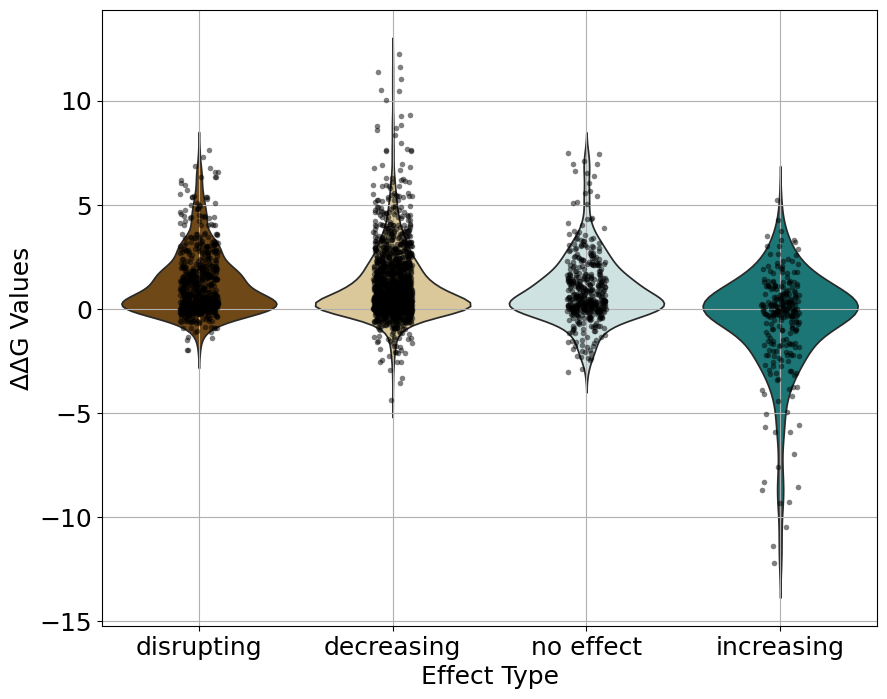

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 label_ddg 和 pred_ddg 已经定义
data = pd.DataFrame({
    'label_ddg': label_ddg,
    'pred_ddg': pred_ddg
})

# 绘制云雨图
plt.figure(figsize=(10, 8))
sns.violinplot(x='pred_ddg', y='label_ddg', data=data, palette=['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585'], inner=None)
sns.stripplot(x='pred_ddg', y='label_ddg', data=data, color='k', alpha=0.5, size=4)

# 设置字体大小
plt.xlabel('Effect Type', fontsize=18)
plt.ylabel('ΔΔG Values', fontsize=18)
plt.xticks(ticks=[0, 1, 2, 3], labels=['disrupting', 'decreasing', 'no effect', 'increasing'], fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.savefig('manything/photo/plot_DDG.png', dpi=300, bbox_inches='tight')
# 显示图形
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 label_ddg 和 pred_ddg 已经定义
data = pd.DataFrame({
    'label_ddg': label_ddg,
    'pred_ddg': pred_ddg
})

# 绘制云雨图
plt.figure(figsize=(10, 8))
sns.violinplot(x='label_ddg', y='pred_ddg', data=data, palette=['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585'], inner=None)
sns.stripplot(x='label_ddg', y='pred_ddg', data=data, color='k', alpha=0.5, size=4)

# 设置字体大小
plt.xlabel('Effect Type', fontsize=18)
plt.ylabel('ΔΔG Values', fontsize=18)
plt.xticks(ticks=[0, 1, 2, 3], labels=['disrupting', 'decreasing', 'no effect', 'increasing'], fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.savefig('manything/photo/plot_DDG.png', dpi=300, bbox_inches='tight')
# 显示图形
plt.show()

/tmp/ipykernel_104456/421559016.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label_ddg', y='pred_ddg', data=data, palette=['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585'], inner=None)
/tmp/ipykernel_104456/421559016.py:13: UserWarning: 
The palette list has fewer values (4) than needed (2232) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x='label_ddg', y='pred_ddg', data=data, palette=['#7E4909', '#E5CC8F', '#CCE5E5', '#0E8585'], inner=None)


Kruskal-Wallis H检验统计量: 145.81506762603334, p值: 2.105959338162781e-31
两两比较的显著性结果：
              0             1             2             3
0  1.000000e+00  6.931454e-02  2.055024e-03  2.198705e-29
1  6.931454e-02  1.000000e+00  4.032138e-02  1.103744e-28
2  2.055024e-03  4.032138e-02  1.000000e+00  4.158044e-15
3  2.198705e-29  1.103744e-28  4.158044e-15  1.000000e+00


/tmp/ipykernel_1242452/2087979123.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='pred_ddg', y='label_ddg', data=data, palette="muted")


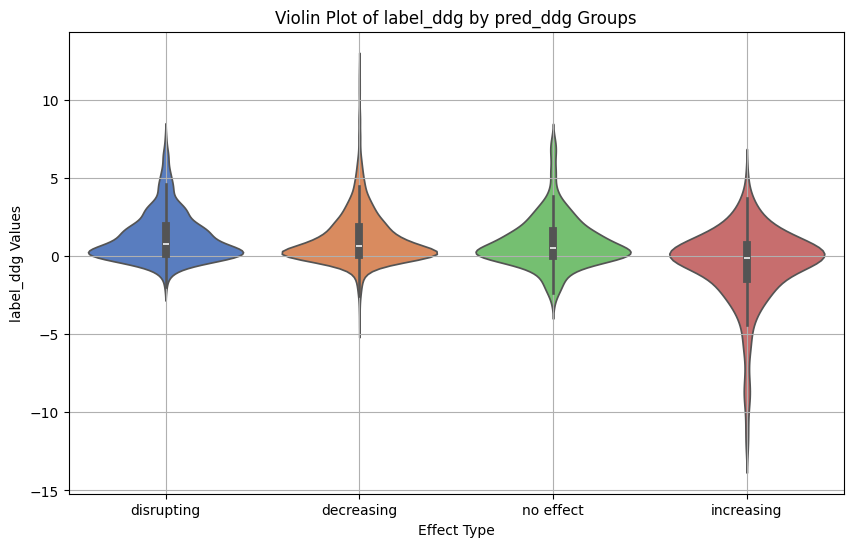

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import scikit_posthocs as sp

# 创建 DataFrame
data = pd.DataFrame({
    'label_ddg': label_ddg,
    'pred_ddg': pred_ddg
})

# 分组数据
grouped_data = [data[data['pred_ddg'] == i]['label_ddg'] for i in range(4)]

# 进行 Kruskal-Wallis H 检验
stat, p_value = kruskal(*grouped_data)
print(f"Kruskal-Wallis H检验统计量: {stat}, p值: {p_value}")

# 如果 p 值显著，进行 Dunn's 检验
if p_value < 0.05:
    # 进行 Dunn's 检验
    dunn_results = sp.posthoc_dunn(data, val_col='label_ddg', group_col='pred_ddg', p_adjust='holm')
    print("两两比较的显著性结果：")
    print(dunn_results)

# 绘制小提琴图
plt.figure(figsize=(10, 6))
sns.violinplot(x='pred_ddg', y='label_ddg', data=data, palette="muted")
plt.xticks(ticks=[0, 1, 2, 3], labels=['disrupting', 'decreasing', 'no effect', 'increasing'])
plt.title('Violin Plot of label_ddg by pred_ddg Groups')
plt.xlabel('Effect Type')
plt.ylabel('label_ddg Values')
plt.grid()
plt.show()

In [152]:
import json
with open('label_ddg.json', 'w') as json_file:
    json.dump(label_ddg, json_file)
with open('pred_ddg.json', 'w') as json_file:
    json.dump(pred_ddg, json_file)